In [2]:
import torch
torch.manual_seed(42) # Set Seed for reproducibility
from torch.utils.data import Dataset
from torchtext.vocab import build_vocab_from_iterator, Vocab
from torch.nn.utils.rnn import pad_sequence

In [4]:
from google.colab import files

uploaded = files.upload()

Saving en_atis-ud-test.conllu to en_atis-ud-test.conllu


In [3]:
!pip install conllu

In [4]:
import conllu

def read_conllu(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        data = f.read()
    return conllu.parse(data)

In [55]:
START_TOKEN = "<s>"
END_TOKEN = "</s>"
UNKNOWN_TOKEN = "<unk>"
PAD_TOKEN = "<pad>"
UNKNOWN_POS = "<upos>"

class EntityDataset(Dataset):
    def __init__(self, data, p, s, posTags:Vocab|None=None, vocabulary:Vocab|None=None):
        """Initialize the dataset. Setup Code goes here"""
        self.windows = []
        self.labels = []
        self.posTags = posTags
        for sentence in data:
            for token in sentence:
                curr_window = []
                idx = token["id"]
                if idx - p < 1:
                    curr_window.extend([START_TOKEN] * (p - idx + 1))
                start = max(1, idx - p)
                end = min(len(sentence), idx + p)
                for i in range(start, end + 1):
                    curr_window.append(sentence[i - 1]["form"])
                if idx + p > len(sentence):
                    curr_window.extend([END_TOKEN] * (idx + p - len(sentence)))
                if posTags is None or token["upos"] in posTags:
                    self.windows.append(curr_window)
                    self.labels.append(token["upos"])

        if vocabulary is None:
            self.vocabulary = build_vocab_from_iterator(self.windows, min_freq=2 ,specials=[START_TOKEN, END_TOKEN, UNKNOWN_TOKEN, PAD_TOKEN])
            self.vocabulary.set_default_index(self.vocabulary[UNKNOWN_TOKEN])
        else:
            self.vocabulary = vocabulary

        if posTags is None:
            self.posTags = build_vocab_from_iterator([self.labels], specials=[UNKNOWN_POS])
            self.posTags.set_default_index(self.posTags[UNKNOWN_POS])
        else:
            self.posTags = posTags

    def __len__(self) -> int:
        """Returns number of datapoints."""
        return len(self.windows)

    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        """Get the datapoint at `index`."""
        return torch.tensor(self.vocabulary.lookup_indices(self.windows[index])), torch.tensor(self.posTags[self.labels[index]])

In [56]:
data = read_conllu("en_atis-ud-train.conllu")
dataset = EntityDataset(data,2,2)
print(dataset.posTags.get_stoi())




{'INTJ': 13, '<upos>': 0, 'DET': 5, 'PRON': 6, 'ADP': 2, 'ADJ': 8, 'NOUN': 3, 'PROPN': 1, 'NUM': 9, 'VERB': 4, 'AUX': 7, 'CCONJ': 10, 'ADV': 11, 'PART': 12}


In [57]:
class FFNN(torch.nn.Module):
    def __init__(self, vocabulary_size: int, p, s, embed_size, num_classes, hidden_sizes, activation):
        super().__init__()

        self.embedding_module = torch.nn.Embedding(vocabulary_size, embed_size)
        self.p = p
        self.s = s

        # Convert activation to list if it's a single value
        if not isinstance(activation, list):
            activation = [activation] * len(hidden_sizes)

        # Create hidden layers dynamically
        layers = []
        prev_size = embed_size * (p + s + 1)
        for size, act in zip(hidden_sizes, activation):
            layers.append(torch.nn.Linear(prev_size, size))
            if act == 'relu':
                layers.append(torch.nn.ReLU())
            elif act == 'sigmoid':
                layers.append(torch.nn.Sigmoid())
            elif act == 'tanh':
                layers.append(torch.nn.Tanh())
            prev_size = size

        self.entity_predictor = torch.nn.Sequential(
            *layers,
            torch.nn.Linear(prev_size, num_classes)
        )

    def forward(self, word_index: torch.Tensor):
        # Take the word index and return an "unnormalized probability distribution" over the labels (1 and 0)
        embedding = self.embedding_module(word_index)
        flattened_list = []
        for embed in embedding:
            flattened_embed = embed.view(-1)
            flattened_list.append(flattened_embed)
        embedding = torch.stack(flattened_list, dim=0)

        return self.entity_predictor(embedding)




In [58]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
classifier = FFNN(len(dataset.vocabulary),2,2,32,len(dataset.posTags),[64],'relu')
loss_fn = torch.nn.CrossEntropyLoss() # use ignore index to ignore losses for padding value indices
optimizer = torch.optim.SGD(classifier.parameters(), lr=0.01)
val_data = read_conllu("en_atis-ud-dev.conllu")
val_dataset = EntityDataset(val_data,2,2,dataset.posTags,dataset.vocabulary)
val_dataloader = DataLoader(val_dataset, batch_size=3) # dont shuffle here for consistent evaluation


for epoch_num in range(10):
  # Put model in training mode
  classifier.train()
  for batch_num, (window, tags) in enumerate(dataloader):
    pred = classifier(window)

    loss = loss_fn(pred, tags)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch_num % 100 == 0:
      # print loss every 2 steps
      print(f"{batch_num=}, {loss.item()=}")
  # Put model in evalutaion mode


classifier.eval()
with torch.no_grad():
    # Can experiment calculating accuracies
  test_loss = 0
  for batch_num, (words, tags) in enumerate(val_dataloader):
    pred = classifier(words)
    test_loss += loss_fn(pred, tags)
print(f"Validation error: {test_loss/len(val_dataloader)}")

from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

# Assuming your model is named 'model' and your test dataloader is named 'test_loader'

# Set model to evaluation mode
classifier.eval()

true_labels = []
predicted_labels = []

# Iterate over test set
for words, labels in val_dataloader:
    # Forward pass
    outputs = classifier(words)

    # Get predicted labels
    _, predicted = torch.max(outputs, 1)

    # Append true and predicted labels
    true_labels.extend(labels.tolist())
    predicted_labels.extend(predicted.tolist())

# Compute evaluation metrics
print(true_labels,predicted)
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels,average="weighted")
f1 = f1_score(true_labels, predicted_labels,average="weighted")
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)



batch_num=0, loss.item()=2.6229231357574463
batch_num=100, loss.item()=2.054324150085449
batch_num=200, loss.item()=1.6046409606933594
batch_num=300, loss.item()=1.539941430091858
batch_num=400, loss.item()=1.3340647220611572
batch_num=500, loss.item()=1.2599024772644043
batch_num=600, loss.item()=1.1793344020843506
batch_num=700, loss.item()=0.9439529180526733
batch_num=0, loss.item()=1.0021593570709229
batch_num=100, loss.item()=0.9881420731544495
batch_num=200, loss.item()=1.0072163343429565
batch_num=300, loss.item()=0.9423710107803345
batch_num=400, loss.item()=0.8373396396636963
batch_num=500, loss.item()=1.045572280883789
batch_num=600, loss.item()=0.9119963645935059
batch_num=700, loss.item()=0.6300833225250244
batch_num=0, loss.item()=0.9942389130592346
batch_num=100, loss.item()=0.8066877722740173
batch_num=200, loss.item()=0.730643093585968
batch_num=300, loss.item()=0.6018847227096558
batch_num=400, loss.item()=0.7805038094520569
batch_num=500, loss.item()=0.625576019287109

In [59]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
classifier = FFNN(len(dataset.vocabulary),2,2,32,len(dataset.posTags),[64],'relu')
loss_fn = torch.nn.CrossEntropyLoss() # use ignore index to ignore losses for padding value indices
optimizer = torch.optim.SGD(classifier.parameters(), lr=0.05)
val_data = read_conllu("en_atis-ud-dev.conllu")
val_dataset = EntityDataset(val_data,2,2,dataset.posTags,dataset.vocabulary)
val_dataloader = DataLoader(val_dataset, batch_size=3) # dont shuffle here for consistent evaluation


for epoch_num in range(10):
  # Put model in training mode
  classifier.train()
  for batch_num, (window, tags) in enumerate(dataloader):
    pred = classifier(window)

    loss = loss_fn(pred, tags)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch_num % 100 == 0:
      # print loss every 2 steps
      print(f"{batch_num=}, {loss.item()=}")
  # Put model in evalutaion mode


classifier.eval()
with torch.no_grad():
    # Can experiment calculating accuracies
  test_loss = 0
  for batch_num, (words, tags) in enumerate(val_dataloader):
    pred = classifier(words)
    test_loss += loss_fn(pred, tags)
print(f"Validation error: {test_loss/len(val_dataloader)}")

from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

# Assuming your model is named 'model' and your test dataloader is named 'test_loader'

# Set model to evaluation mode
classifier.eval()

true_labels = []
predicted_labels = []

# Iterate over test set
for words, labels in val_dataloader:
    # Forward pass
    outputs = classifier(words)

    # Get predicted labels
    _, predicted = torch.max(outputs, 1)

    # Append true and predicted labels
    true_labels.extend(labels.tolist())
    predicted_labels.extend(predicted.tolist())

# Compute evaluation metrics
print(true_labels,predicted)
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels,average="weighted")
f1 = f1_score(true_labels, predicted_labels,average="weighted")
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)



batch_num=0, loss.item()=2.6904730796813965
batch_num=100, loss.item()=1.265150785446167
batch_num=200, loss.item()=1.3168771266937256
batch_num=300, loss.item()=0.8788182735443115
batch_num=400, loss.item()=0.5722192525863647
batch_num=500, loss.item()=0.5630683898925781
batch_num=600, loss.item()=0.45975539088249207
batch_num=700, loss.item()=0.5767647624015808
batch_num=0, loss.item()=0.72386634349823
batch_num=100, loss.item()=0.35376012325286865
batch_num=200, loss.item()=0.41214823722839355
batch_num=300, loss.item()=0.3874790668487549
batch_num=400, loss.item()=0.3740118741989136
batch_num=500, loss.item()=0.2313689887523651
batch_num=600, loss.item()=0.3439772129058838
batch_num=700, loss.item()=0.2788242995738983
batch_num=0, loss.item()=0.23355533182621002
batch_num=100, loss.item()=0.33447006344795227
batch_num=200, loss.item()=0.26894810795783997
batch_num=300, loss.item()=0.3542928397655487
batch_num=400, loss.item()=0.1992027312517166
batch_num=500, loss.item()=0.25858053

In [60]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
classifier = FFNN(len(dataset.vocabulary),2,2,32,len(dataset.posTags),[64],'relu')
loss_fn = torch.nn.CrossEntropyLoss() # use ignore index to ignore losses for padding value indices
optimizer = torch.optim.SGD(classifier.parameters(), lr=0.2)
val_data = read_conllu("en_atis-ud-dev.conllu")
val_dataset = EntityDataset(val_data,2,2,dataset.posTags,dataset.vocabulary)
val_dataloader = DataLoader(val_dataset, batch_size=3) # dont shuffle here for consistent evaluation


for epoch_num in range(10):
  # Put model in training mode
  classifier.train()
  for batch_num, (window, tags) in enumerate(dataloader):
    pred = classifier(window)

    loss = loss_fn(pred, tags)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch_num % 100 == 0:
      # print loss every 2 steps
      print(f"{batch_num=}, {loss.item()=}")
  # Put model in evalutaion mode


classifier.eval()
with torch.no_grad():
    # Can experiment calculating accuracies
  test_loss = 0
  for batch_num, (words, tags) in enumerate(val_dataloader):
    pred = classifier(words)
    test_loss += loss_fn(pred, tags)
print(f"Validation error: {test_loss/len(val_dataloader)}")

from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

# Assuming your model is named 'model' and your test dataloader is named 'test_loader'

# Set model to evaluation mode
classifier.eval()

true_labels = []
predicted_labels = []

# Iterate over test set
for words, labels in val_dataloader:
    # Forward pass
    outputs = classifier(words)

    # Get predicted labels
    _, predicted = torch.max(outputs, 1)

    # Append true and predicted labels
    true_labels.extend(labels.tolist())
    predicted_labels.extend(predicted.tolist())

# Compute evaluation metrics
print(true_labels,predicted)
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels,average="weighted")
f1 = f1_score(true_labels, predicted_labels,average="weighted")
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)



batch_num=0, loss.item()=2.6981117725372314
batch_num=100, loss.item()=0.7024965882301331
batch_num=200, loss.item()=0.3928331732749939
batch_num=300, loss.item()=0.20031745731830597
batch_num=400, loss.item()=0.28679096698760986
batch_num=500, loss.item()=0.42953816056251526
batch_num=600, loss.item()=0.3261848986148834
batch_num=700, loss.item()=0.10723601281642914
batch_num=0, loss.item()=0.25509122014045715
batch_num=100, loss.item()=0.17388363182544708
batch_num=200, loss.item()=0.26328879594802856
batch_num=300, loss.item()=0.14193081855773926
batch_num=400, loss.item()=0.28649190068244934
batch_num=500, loss.item()=0.12352046370506287
batch_num=600, loss.item()=0.1127634271979332
batch_num=700, loss.item()=0.3404777944087982
batch_num=0, loss.item()=0.07343710213899612
batch_num=100, loss.item()=0.08264318108558655
batch_num=200, loss.item()=0.12439987808465958
batch_num=300, loss.item()=0.15399813652038574
batch_num=400, loss.item()=0.21874725818634033
batch_num=500, loss.item(

In [70]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
classifier = FFNN(len(dataset.vocabulary),2,2,32,len(dataset.posTags),[64],'relu')
loss_fn = torch.nn.CrossEntropyLoss() # use ignore index to ignore losses for padding value indices
optimizer = torch.optim.SGD(classifier.parameters(), lr=0.5)
val_data = read_conllu("en_atis-ud-dev.conllu")
val_dataset = EntityDataset(val_data,2,2,dataset.posTags,dataset.vocabulary)
val_dataloader = DataLoader(val_dataset, batch_size=3) # dont shuffle here for consistent evaluation


for epoch_num in range(10):
  # Put model in training mode
  classifier.train()
  for batch_num, (window, tags) in enumerate(dataloader):
    pred = classifier(window)

    loss = loss_fn(pred, tags)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch_num % 100 == 0:
      # print loss every 2 steps
      print(f"{batch_num=}, {loss.item()=}")
  # Put model in evalutaion mode


classifier.eval()
with torch.no_grad():
    # Can experiment calculating accuracies
  test_loss = 0
  for batch_num, (words, tags) in enumerate(val_dataloader):
    pred = classifier(words)
    test_loss += loss_fn(pred, tags)
print(f"Validation error: {test_loss/len(val_dataloader)}")

from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

# Assuming your model is named 'model' and your test dataloader is named 'test_loader'

# Set model to evaluation mode
classifier.eval()

true_labels = []
predicted_labels = []

# Iterate over test set
for words, labels in val_dataloader:
    # Forward pass
    outputs = classifier(words)

    # Get predicted labels
    _, predicted = torch.max(outputs, 1)

    # Append true and predicted labels
    true_labels.extend(labels.tolist())
    predicted_labels.extend(predicted.tolist())

# Compute evaluation metrics
print(true_labels,predicted)
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels,average="weighted")
f1 = f1_score(true_labels, predicted_labels,average="weighted")
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)



RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x288 and 160x64)

In [39]:
print(true_labels)
print(predicted_labels)

[6, 7, 4, 5, 8, 3, 2, 1, 2, 1, 4, 3, 9, 8, 10, 4, 3, 8, 6, 4, 5, 3, 2, 1, 2, 1, 2, 4, 5, 11, 2, 9, 3, 4, 6, 3, 3, 3, 2, 1, 2, 1, 4, 8, 3, 10, 4, 5, 3, 2, 6, 7, 1, 1, 4, 2, 2, 3, 4, 6, 5, 3, 2, 1, 2, 1, 5, 4, 2, 9, 11, 3, 5, 3, 2, 3, 5, 3, 2, 1, 2, 1, 4, 8, 2, 5, 3, 7, 6, 4, 3, 2, 3, 2, 1, 1, 2, 1, 1, 4, 2, 3, 4, 5, 1, 1, 3, 2, 1, 4, 5, 3, 4, 2, 1, 2, 1, 1, 2, 1, 3, 4, 2, 2, 1, 1, 6, 7, 3, 1, 6, 4, 3, 2, 3, 3, 1, 1, 6, 7, 5, 8, 3, 2, 1, 1, 2, 1, 4, 2, 3, 3, 9, 9, 6, 7, 4, 2, 4, 5, 3, 2, 3, 8, 2, 1, 1, 2, 1, 2, 5, 8, 3, 6, 7, 3, 3, 1, 10, 11, 4, 6, 3, 3, 2, 6, 7, 4, 2, 1, 8, 3, 4, 6, 5, 8, 3, 2, 1, 2, 1, 2, 4, 2, 5, 3, 10, 4, 2, 9, 3, 10, 9, 3, 2, 3, 6, 7, 4, 12, 4, 2, 1, 1, 1, 2, 1, 1, 6, 7, 4, 2, 4, 2, 1, 2, 9, 3, 4, 6, 5, 3, 3, 2, 1, 1, 7, 6, 4, 6, 3, 2, 7, 3, 3, 2, 1, 2, 1, 3, 2, 1, 2, 1, 2, 9, 3, 10, 9, 3, 5, 3, 7, 4, 2, 1, 3, 9, 2, 1, 2, 1, 6, 4, 12, 4, 2, 1, 2, 1, 10, 11, 2, 5, 8, 3, 4, 6, 5, 8, 3, 2, 1, 6, 7, 5, 11, 4, 3, 2, 1, 2, 1, 6, 7, 5, 8, 3, 10, 1, 3, 2, 3, 2, 1, 2, 1, 1, 

In [43]:
val_data = read_conllu("en_atis-ud-test.conllu")
val_dataset = EntityDataset(val_data,2,2,dataset.posTags,dataset.vocabulary)
val_dataloader = DataLoader(val_dataset, batch_size=3) # dont shuffle here for consistent evaluation
classifier.eval()

true_labels = []
predicted_labels = []

# Iterate over test set
for words, labels in val_dataloader:
    # Forward pass
    outputs = classifier(words)

    # Get predicted labels
    _, predicted = torch.max(outputs, 1)

    # Append true and predicted labels
    true_labels.extend(labels.tolist())
    predicted_labels.extend(predicted.tolist())

# Compute evaluation metrics
print(true_labels)
print(predicted_labels)
for i in val_dataloader:
  print(i)
  break

accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels,average="weighted")
f1 = f1_score(true_labels, predicted_labels,average="weighted")
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

[6, 7, 5, 3, 3, 2, 1, 10, 1, 4, 3, 8, 10, 4, 3, 9, 6, 4, 5, 3, 2, 1, 2, 1, 2, 4, 5, 8, 2, 9, 3, 6, 4, 5, 3, 4, 1, 1, 2, 1, 4, 8, 3, 10, 4, 5, 4, 3, 4, 3, 3, 1, 1, 4, 6, 5, 3, 2, 1, 2, 1, 1, 6, 4, 5, 3, 2, 3, 2, 9, 11, 3, 6, 4, 5, 3, 2, 1, 2, 1, 4, 1, 8, 2, 3, 4, 6, 5, 3, 2, 1, 1, 2, 1, 1, 4, 2, 3, 4, 6, 3, 3, 2, 1, 2, 3, 3, 4, 5, 3, 2, 1, 2, 1, 1, 2, 5, 3, 2, 1, 2, 1, 1, 6, 7, 3, 1, 4, 5, 1, 1, 6, 7, 5, 3, 3, 2, 1, 1, 10, 1, 1, 2, 1, 1, 2, 1, 2, 3, 3, 9, 9, 5, 3, 7, 5, 8, 3, 3, 4, 2, 1, 2, 1, 6, 7, 5, 3, 3, 1, 4, 2, 4, 6, 3, 3, 2, 5, 1, 1, 2, 1, 11, 2, 6, 4, 2, 9, 2, 5, 3, 5, 3, 2, 1, 10, 1, 4, 2, 1, 2, 9, 3, 10, 9, 3, 6, 7, 5, 3, 2, 1, 2, 4, 2, 1, 11, 1, 2, 1, 1, 5, 3, 2, 3, 3, 4, 6, 2, 1, 1, 2, 3, 3, 2, 1, 2, 1, 4, 3, 8, 6, 7, 4, 12, 4, 6, 7, 5, 8, 3, 8, 4, 3, 2, 1, 2, 1, 1, 2, 9, 3, 10, 9, 3, 2, 3, 5, 3, 7, 8, 2, 1, 9, 5, 1, 4, 2, 1, 1, 2, 9, 3, 6, 4, 12, 4, 2, 1, 1, 2, 1, 8, 3, 4, 2, 5, 3, 10, 4, 5, 8, 3, 13, 4, 2, 6, 5, 3, 2, 1, 2, 1, 1, 2, 1, 1, 11, 8, 3, 4, 6, 5, 8, 3, 3, 2, 1, 

In [49]:
print(val_dataset.vocabulary.lookup_token(30))
print(val_dataset.posTags.lookup_token(7))

are
AUX


In [35]:
torch.save(classifier, "ffn.pt")
torch.save(dataset.vocabulary,"ffnVocab.pt")
torch.save(dataset.posTags,"ffnTags.pt")
print(classifier)

FFNN(
  (embedding_module): Embedding(867, 32)
  (entity_predictor): Sequential(
    (0): Linear(in_features=160, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=14, bias=True)
  )
)


In [15]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=3, shuffle=True)
classifier = FFNN(len(dataset.vocabulary),2,2,32,len(dataset.posTags),[64],'relu')
loss_fn = torch.nn.CrossEntropyLoss() # use ignore index to ignore losses for padding value indices
optimizer = torch.optim.SGD(classifier.parameters(), lr=1e-1)
val_data = read_conllu("en_atis-ud-dev.conllu")
val_dataset = EntityDataset(val_data,2,2,dataset.posTags,dataset.vocabulary)
val_dataloader = DataLoader(val_dataset, batch_size=3) # dont shuffle here for consistent evaluation


for epoch_num in range(10):
  # Put model in training mode
  classifier.train()
  for batch_num, (window, tags) in enumerate(dataloader):
    pred = classifier(window)

    loss = loss_fn(pred, tags)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch_num % 100 == 0:
      # print loss every 2 steps
      print(f"{batch_num=}, {loss.item()=}")
  # Put model in evalutaion mode


classifier.eval()
with torch.no_grad():
    # Can experiment calculating accuracies
  test_loss = 0
  for batch_num, (words, tags) in enumerate(val_dataloader):
    pred = classifier(words)
    test_loss += loss_fn(pred, tags)
print(f"Validation error: {test_loss/len(val_dataloader)}")

from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

# Assuming your model is named 'model' and your test dataloader is named 'test_loader'

# Set model to evaluation mode
classifier.eval()

true_labels = []
predicted_labels = []

# Iterate over test set
for words, labels in val_dataloader:
    # Forward pass
    outputs = classifier(words)

    # Get predicted labels
    _, predicted = torch.max(outputs, 1)

    # Append true and predicted labels
    true_labels.extend(labels.tolist())
    predicted_labels.extend(predicted.tolist())

# Compute evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels,average="weighted")
f1 = f1_score(true_labels, predicted_labels,average="weighted")
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)






batch_num=0, loss.item()=2.763676881790161
batch_num=100, loss.item()=3.346959352493286
batch_num=200, loss.item()=1.2296948432922363
batch_num=300, loss.item()=0.03641582652926445
batch_num=400, loss.item()=0.27584558725357056
batch_num=500, loss.item()=1.6848602294921875
batch_num=600, loss.item()=0.09160971641540527
batch_num=700, loss.item()=0.058286990970373154
batch_num=800, loss.item()=0.8845693469047546
batch_num=900, loss.item()=0.8391587138175964
batch_num=1000, loss.item()=3.618738889694214
batch_num=1100, loss.item()=0.07582005113363266
batch_num=1200, loss.item()=4.518746852874756
batch_num=1300, loss.item()=0.19286184012889862
batch_num=1400, loss.item()=0.07589346915483475
batch_num=1500, loss.item()=0.03099512867629528
batch_num=1600, loss.item()=3.3360297679901123
batch_num=1700, loss.item()=0.38665762543678284
batch_num=1800, loss.item()=2.340268850326538
batch_num=1900, loss.item()=0.019919661805033684
batch_num=2000, loss.item()=0.10046708583831787
batch_num=2100, l

In [16]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=3, shuffle=True)
classifier = FFNN(len(dataset.vocabulary),2,2,32,len(dataset.posTags),[128],'relu')
loss_fn = torch.nn.CrossEntropyLoss() # use ignore index to ignore losses for padding value indices
optimizer = torch.optim.SGD(classifier.parameters(), lr=1e-1)
val_data = read_conllu("en_atis-ud-dev.conllu")
val_dataset = EntityDataset(val_data,2,2,dataset.posTags,dataset.vocabulary)
val_dataloader = DataLoader(val_dataset, batch_size=3) # dont shuffle here for consistent evaluation


for epoch_num in range(10):
  # Put model in training mode
  classifier.train()
  for batch_num, (window, tags) in enumerate(dataloader):
    pred = classifier(window)

    loss = loss_fn(pred, tags)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch_num % 100 == 0:
      # print loss every 2 steps
      print(f"{batch_num=}, {loss.item()=}")
  # Put model in evalutaion mode


classifier.eval()
with torch.no_grad():
    # Can experiment calculating accuracies
  test_loss = 0
  for batch_num, (words, tags) in enumerate(val_dataloader):
    pred = classifier(words)
    test_loss += loss_fn(pred, tags)
print(f"Validation error: {test_loss/len(val_dataloader)}")

from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

# Assuming your model is named 'model' and your test dataloader is named 'test_loader'

# Set model to evaluation mode
classifier.eval()

true_labels = []
predicted_labels = []

# Iterate over test set
for words, labels in val_dataloader:
    # Forward pass
    outputs = classifier(words)

    # Get predicted labels
    _, predicted = torch.max(outputs, 1)

    # Append true and predicted labels
    true_labels.extend(labels.tolist())
    predicted_labels.extend(predicted.tolist())

# Compute evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels,average="weighted")
f1 = f1_score(true_labels, predicted_labels,average="weighted")
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)






batch_num=0, loss.item()=2.546440362930298
batch_num=100, loss.item()=0.9844806790351868
batch_num=200, loss.item()=0.8075129985809326
batch_num=300, loss.item()=1.948625922203064
batch_num=400, loss.item()=2.145848035812378
batch_num=500, loss.item()=1.6364368200302124
batch_num=600, loss.item()=1.0137364864349365
batch_num=700, loss.item()=0.005456916522234678
batch_num=800, loss.item()=0.9913553595542908
batch_num=900, loss.item()=0.03330565616488457
batch_num=1000, loss.item()=1.2844805717468262
batch_num=1100, loss.item()=1.0792351961135864
batch_num=1200, loss.item()=0.0030544735491275787
batch_num=1300, loss.item()=0.8386252522468567
batch_num=1400, loss.item()=0.05329837277531624
batch_num=1500, loss.item()=0.047746073454618454
batch_num=1600, loss.item()=0.037410441786050797
batch_num=1700, loss.item()=0.17984366416931152
batch_num=1800, loss.item()=1.0884264707565308
batch_num=1900, loss.item()=0.017526032403111458
batch_num=2000, loss.item()=0.13117124140262604
batch_num=210

In [17]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=3, shuffle=True)
classifier = FFNN(len(dataset.vocabulary),2,2,32,len(dataset.posTags),[32,16],'relu')
loss_fn = torch.nn.CrossEntropyLoss() # use ignore index to ignore losses for padding value indices
optimizer = torch.optim.SGD(classifier.parameters(), lr=1e-1)
val_data = read_conllu("en_atis-ud-dev.conllu")
val_dataset = EntityDataset(val_data,2,2,dataset.posTags,dataset.vocabulary)
val_dataloader = DataLoader(val_dataset, batch_size=3) # dont shuffle here for consistent evaluation


for epoch_num in range(10):
  # Put model in training mode
  classifier.train()
  for batch_num, (window, tags) in enumerate(dataloader):
    pred = classifier(window)

    loss = loss_fn(pred, tags)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch_num % 100 == 0:
      # print loss every 2 steps
      print(f"{batch_num=}, {loss.item()=}")
  # Put model in evalutaion mode


classifier.eval()
with torch.no_grad():
    # Can experiment calculating accuracies
  test_loss = 0
  for batch_num, (words, tags) in enumerate(val_dataloader):
    pred = classifier(words)
    test_loss += loss_fn(pred, tags)
print(f"Validation error: {test_loss/len(val_dataloader)}")

from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

# Assuming your model is named 'model' and your test dataloader is named 'test_loader'

# Set model to evaluation mode
classifier.eval()

true_labels = []
predicted_labels = []

# Iterate over test set
for words, labels in val_dataloader:
    # Forward pass
    outputs = classifier(words)

    # Get predicted labels
    _, predicted = torch.max(outputs, 1)

    # Append true and predicted labels
    true_labels.extend(labels.tolist())
    predicted_labels.extend(predicted.tolist())

# Compute evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels,average="weighted")
f1 = f1_score(true_labels, predicted_labels,average="weighted")
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)






batch_num=0, loss.item()=2.6905081272125244
batch_num=100, loss.item()=1.2353525161743164
batch_num=200, loss.item()=1.5078550577163696
batch_num=300, loss.item()=2.100815773010254
batch_num=400, loss.item()=1.1437329053878784
batch_num=500, loss.item()=1.0109423398971558
batch_num=600, loss.item()=2.038268804550171
batch_num=700, loss.item()=0.557387113571167
batch_num=800, loss.item()=1.2531744241714478
batch_num=900, loss.item()=2.673997163772583
batch_num=1000, loss.item()=0.04290691390633583
batch_num=1100, loss.item()=0.006700780708342791
batch_num=1200, loss.item()=1.0441473722457886
batch_num=1300, loss.item()=0.22305119037628174
batch_num=1400, loss.item()=0.307653546333313
batch_num=1500, loss.item()=1.4006983041763306
batch_num=1600, loss.item()=0.08256375044584274
batch_num=1700, loss.item()=0.05687464401125908
batch_num=1800, loss.item()=0.6762397289276123
batch_num=1900, loss.item()=1.5250283479690552
batch_num=2000, loss.item()=0.6710317134857178
batch_num=2100, loss.ite

In [18]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=3, shuffle=True)
classifier = FFNN(len(dataset.vocabulary),2,2,32,len(dataset.posTags),[64,32],'relu')
loss_fn = torch.nn.CrossEntropyLoss() # use ignore index to ignore losses for padding value indices
optimizer = torch.optim.SGD(classifier.parameters(), lr=1e-1)
val_data = read_conllu("en_atis-ud-dev.conllu")
val_dataset = EntityDataset(val_data,2,2,dataset.posTags,dataset.vocabulary)
val_dataloader = DataLoader(val_dataset, batch_size=3) # dont shuffle here for consistent evaluation


for epoch_num in range(10):
  # Put model in training mode
  classifier.train()
  for batch_num, (window, tags) in enumerate(dataloader):
    pred = classifier(window)

    loss = loss_fn(pred, tags)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch_num % 100 == 0:
      # print loss every 2 steps
      print(f"{batch_num=}, {loss.item()=}")
  # Put model in evalutaion mode


classifier.eval()
with torch.no_grad():
    # Can experiment calculating accuracies
  test_loss = 0
  for batch_num, (words, tags) in enumerate(val_dataloader):
    pred = classifier(words)
    test_loss += loss_fn(pred, tags)
print(f"Validation error: {test_loss/len(val_dataloader)}")

from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

# Assuming your model is named 'model' and your test dataloader is named 'test_loader'

# Set model to evaluation mode
classifier.eval()

true_labels = []
predicted_labels = []

# Iterate over test set
for words, labels in val_dataloader:
    # Forward pass
    outputs = classifier(words)

    # Get predicted labels
    _, predicted = torch.max(outputs, 1)

    # Append true and predicted labels
    true_labels.extend(labels.tolist())
    predicted_labels.extend(predicted.tolist())

# Compute evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels,average="weighted")
f1 = f1_score(true_labels, predicted_labels,average="weighted")
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)






batch_num=0, loss.item()=2.701327085494995
batch_num=100, loss.item()=0.4248250722885132
batch_num=200, loss.item()=2.2767016887664795
batch_num=300, loss.item()=0.7843046188354492
batch_num=400, loss.item()=0.7962213158607483
batch_num=500, loss.item()=1.0025333166122437
batch_num=600, loss.item()=0.9469664692878723
batch_num=700, loss.item()=0.030733466148376465
batch_num=800, loss.item()=0.12747730314731598
batch_num=900, loss.item()=0.6815405488014221
batch_num=1000, loss.item()=2.3604538440704346
batch_num=1100, loss.item()=0.20630526542663574
batch_num=1200, loss.item()=0.028510862961411476
batch_num=1300, loss.item()=0.006978604942560196
batch_num=1400, loss.item()=0.43092694878578186
batch_num=1500, loss.item()=0.5310046076774597
batch_num=1600, loss.item()=1.1602975130081177
batch_num=1700, loss.item()=1.7260284423828125
batch_num=1800, loss.item()=6.4101996421813965
batch_num=1900, loss.item()=0.04761848226189613
batch_num=2000, loss.item()=0.26205235719680786
batch_num=2100,

In [19]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=3, shuffle=True)
classifier = FFNN(len(dataset.vocabulary),2,2,32,len(dataset.posTags),[128,64],'relu')
loss_fn = torch.nn.CrossEntropyLoss() # use ignore index to ignore losses for padding value indices
optimizer = torch.optim.SGD(classifier.parameters(), lr=1e-1)
val_data = read_conllu("en_atis-ud-dev.conllu")
val_dataset = EntityDataset(val_data,2,2,dataset.posTags,dataset.vocabulary)
val_dataloader = DataLoader(val_dataset, batch_size=3) # dont shuffle here for consistent evaluation


for epoch_num in range(10):
  # Put model in training mode
  classifier.train()
  for batch_num, (window, tags) in enumerate(dataloader):
    pred = classifier(window)

    loss = loss_fn(pred, tags)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch_num % 100 == 0:
      # print loss every 2 steps
      print(f"{batch_num=}, {loss.item()=}")
  # Put model in evalutaion mode


classifier.eval()
with torch.no_grad():
    # Can experiment calculating accuracies
  test_loss = 0
  for batch_num, (words, tags) in enumerate(val_dataloader):
    pred = classifier(words)
    test_loss += loss_fn(pred, tags)
print(f"Validation error: {test_loss/len(val_dataloader)}")

from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

# Assuming your model is named 'model' and your test dataloader is named 'test_loader'

# Set model to evaluation mode
classifier.eval()

true_labels = []
predicted_labels = []

# Iterate over test set
for words, labels in val_dataloader:
    # Forward pass
    outputs = classifier(words)

    # Get predicted labels
    _, predicted = torch.max(outputs, 1)

    # Append true and predicted labels
    true_labels.extend(labels.tolist())
    predicted_labels.extend(predicted.tolist())

# Compute evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels,average="weighted")
f1 = f1_score(true_labels, predicted_labels,average="weighted")
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)






batch_num=0, loss.item()=2.698270559310913
batch_num=100, loss.item()=1.4318904876708984
batch_num=200, loss.item()=1.200439453125
batch_num=300, loss.item()=1.322229266166687
batch_num=400, loss.item()=0.591529369354248
batch_num=500, loss.item()=0.6283368468284607
batch_num=600, loss.item()=0.47328683733940125
batch_num=700, loss.item()=0.38399556279182434
batch_num=800, loss.item()=0.3996117413043976
batch_num=900, loss.item()=1.2154204845428467
batch_num=1000, loss.item()=1.336256980895996
batch_num=1100, loss.item()=0.02106832154095173
batch_num=1200, loss.item()=2.2146637439727783
batch_num=1300, loss.item()=0.00901736132800579
batch_num=1400, loss.item()=0.9456384778022766
batch_num=1500, loss.item()=0.4161883294582367
batch_num=1600, loss.item()=0.01579461805522442
batch_num=1700, loss.item()=0.018506156280636787
batch_num=1800, loss.item()=0.27131664752960205
batch_num=1900, loss.item()=0.11481606215238571
batch_num=2000, loss.item()=2.5029900074005127
batch_num=2100, loss.ite

In [20]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=3, shuffle=True)
classifier = FFNN(len(dataset.vocabulary),2,2,32,len(dataset.posTags),[64,32,16],'relu')
loss_fn = torch.nn.CrossEntropyLoss() # use ignore index to ignore losses for padding value indices
optimizer = torch.optim.SGD(classifier.parameters(), lr=1e-1)
val_data = read_conllu("en_atis-ud-dev.conllu")
val_dataset = EntityDataset(val_data,2,2,dataset.posTags,dataset.vocabulary)
val_dataloader = DataLoader(val_dataset, batch_size=3) # dont shuffle here for consistent evaluation


for epoch_num in range(10):
  # Put model in training mode
  classifier.train()
  for batch_num, (window, tags) in enumerate(dataloader):
    pred = classifier(window)

    loss = loss_fn(pred, tags)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch_num % 100 == 0:
      # print loss every 2 steps
      print(f"{batch_num=}, {loss.item()=}")
  # Put model in evalutaion mode


classifier.eval()
with torch.no_grad():
    # Can experiment calculating accuracies
  test_loss = 0
  for batch_num, (words, tags) in enumerate(val_dataloader):
    pred = classifier(words)
    test_loss += loss_fn(pred, tags)
print(f"Validation error: {test_loss/len(val_dataloader)}")

from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

# Assuming your model is named 'model' and your test dataloader is named 'test_loader'

# Set model to evaluation mode
classifier.eval()

true_labels = []
predicted_labels = []

# Iterate over test set
for words, labels in val_dataloader:
    # Forward pass
    outputs = classifier(words)

    # Get predicted labels
    _, predicted = torch.max(outputs, 1)

    # Append true and predicted labels
    true_labels.extend(labels.tolist())
    predicted_labels.extend(predicted.tolist())

# Compute evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels,average="weighted")
f1 = f1_score(true_labels, predicted_labels,average="weighted")
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)






batch_num=0, loss.item()=2.756638526916504
batch_num=100, loss.item()=0.9702968597412109
batch_num=200, loss.item()=1.6700843572616577
batch_num=300, loss.item()=1.265109896659851
batch_num=400, loss.item()=2.2013027667999268
batch_num=500, loss.item()=0.7903186678886414
batch_num=600, loss.item()=1.175636649131775
batch_num=700, loss.item()=2.0805394649505615
batch_num=800, loss.item()=0.12722568213939667
batch_num=900, loss.item()=1.2654032707214355
batch_num=1000, loss.item()=1.4398115873336792
batch_num=1100, loss.item()=0.053384631872177124
batch_num=1200, loss.item()=1.891957402229309
batch_num=1300, loss.item()=0.5154576897621155
batch_num=1400, loss.item()=5.928480459260754e-05
batch_num=1500, loss.item()=0.00036358321085572243
batch_num=1600, loss.item()=0.7835400104522705
batch_num=1700, loss.item()=2.5083820819854736
batch_num=1800, loss.item()=2.146648645401001
batch_num=1900, loss.item()=1.0700759887695312
batch_num=2000, loss.item()=0.1444508135318756
batch_num=2100, loss

In [ ]:
print()

In [21]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=3, shuffle=True)
classifier = FFNN(len(dataset.vocabulary),2,2,32,len(dataset.posTags),[128,64,32],'relu')
loss_fn = torch.nn.CrossEntropyLoss() # use ignore index to ignore losses for padding value indices
optimizer = torch.optim.SGD(classifier.parameters(), lr=1e-1)
val_data = read_conllu("en_atis-ud-dev.conllu")
val_dataset = EntityDataset(val_data,2,2,dataset.posTags,dataset.vocabulary)
val_dataloader = DataLoader(val_dataset, batch_size=3) # dont shuffle here for consistent evaluation


for epoch_num in range(10):
  # Put model in training mode
  classifier.train()
  for batch_num, (window, tags) in enumerate(dataloader):
    pred = classifier(window)

    loss = loss_fn(pred, tags)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch_num % 100 == 0:
      # print loss every 2 steps
      print(f"{batch_num=}, {loss.item()=}")
  # Put model in evalutaion mode


classifier.eval()
with torch.no_grad():
    # Can experiment calculating accuracies
  test_loss = 0
  for batch_num, (words, tags) in enumerate(val_dataloader):
    pred = classifier(words)
    test_loss += loss_fn(pred, tags)
print(f"Validation error: {test_loss/len(val_dataloader)}")

from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

# Assuming your model is named 'model' and your test dataloader is named 'test_loader'

# Set model to evaluation mode
classifier.eval()

true_labels = []
predicted_labels = []

# Iterate over test set
for words, labels in val_dataloader:
    # Forward pass
    outputs = classifier(words)

    # Get predicted labels
    _, predicted = torch.max(outputs, 1)

    # Append true and predicted labels
    true_labels.extend(labels.tolist())
    predicted_labels.extend(predicted.tolist())

# Compute evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels,average="weighted")
f1 = f1_score(true_labels, predicted_labels,average="weighted")
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)






batch_num=0, loss.item()=2.6929681301116943
batch_num=100, loss.item()=1.2754895687103271
batch_num=200, loss.item()=1.0387743711471558
batch_num=300, loss.item()=0.4716055691242218
batch_num=400, loss.item()=0.0834631696343422
batch_num=500, loss.item()=2.1039984226226807
batch_num=600, loss.item()=1.4069056510925293
batch_num=700, loss.item()=0.09124847501516342
batch_num=800, loss.item()=0.6548117995262146
batch_num=900, loss.item()=2.050943374633789
batch_num=1000, loss.item()=1.026631474494934
batch_num=1100, loss.item()=1.0491602420806885
batch_num=1200, loss.item()=1.783953070640564
batch_num=1300, loss.item()=0.02931823395192623
batch_num=1400, loss.item()=0.39021965861320496
batch_num=1500, loss.item()=1.62446129322052
batch_num=1600, loss.item()=0.7443413138389587
batch_num=1700, loss.item()=0.3032267093658447
batch_num=1800, loss.item()=0.0005226052016951144
batch_num=1900, loss.item()=0.45996761322021484
batch_num=2000, loss.item()=0.03841264545917511
batch_num=2100, loss.i

In [22]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=3, shuffle=True)
classifier = FFNN(len(dataset.vocabulary),2,2,32,len(dataset.posTags),[128,64,32,16],'relu')
loss_fn = torch.nn.CrossEntropyLoss() # use ignore index to ignore losses for padding value indices
optimizer = torch.optim.SGD(classifier.parameters(), lr=1e-1)
val_data = read_conllu("en_atis-ud-dev.conllu")
val_dataset = EntityDataset(val_data,2,2,dataset.posTags,dataset.vocabulary)
val_dataloader = DataLoader(val_dataset, batch_size=3) # dont shuffle here for consistent evaluation


for epoch_num in range(10):
  # Put model in training mode
  classifier.train()
  for batch_num, (window, tags) in enumerate(dataloader):
    pred = classifier(window)

    loss = loss_fn(pred, tags)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch_num % 100 == 0:
      # print loss every 2 steps
      print(f"{batch_num=}, {loss.item()=}")
  # Put model in evalutaion mode


classifier.eval()
with torch.no_grad():
    # Can experiment calculating accuracies
  test_loss = 0
  for batch_num, (words, tags) in enumerate(val_dataloader):
    pred = classifier(words)
    test_loss += loss_fn(pred, tags)
print(f"Validation error: {test_loss/len(val_dataloader)}")

from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

# Assuming your model is named 'model' and your test dataloader is named 'test_loader'

# Set model to evaluation mode
classifier.eval()

true_labels = []
predicted_labels = []

# Iterate over test set
for words, labels in val_dataloader:
    # Forward pass
    outputs = classifier(words)

    # Get predicted labels
    _, predicted = torch.max(outputs, 1)

    # Append true and predicted labels
    true_labels.extend(labels.tolist())
    predicted_labels.extend(predicted.tolist())

# Compute evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels,average="weighted")
f1 = f1_score(true_labels, predicted_labels,average="weighted")
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)






batch_num=0, loss.item()=2.668062210083008
batch_num=100, loss.item()=1.97512948513031
batch_num=200, loss.item()=2.269824743270874
batch_num=300, loss.item()=1.6068271398544312
batch_num=400, loss.item()=0.6779188513755798
batch_num=500, loss.item()=1.2324234247207642
batch_num=600, loss.item()=0.6889637112617493
batch_num=700, loss.item()=0.7213597297668457
batch_num=800, loss.item()=0.8175213932991028
batch_num=900, loss.item()=0.6150858998298645
batch_num=1000, loss.item()=0.04631669446825981
batch_num=1100, loss.item()=1.618719220161438
batch_num=1200, loss.item()=1.4177254438400269
batch_num=1300, loss.item()=0.014955532737076283
batch_num=1400, loss.item()=0.010829712264239788
batch_num=1500, loss.item()=1.6667321920394897
batch_num=1600, loss.item()=1.2585266828536987
batch_num=1700, loss.item()=1.4828251600265503
batch_num=1800, loss.item()=1.8988906145095825
batch_num=1900, loss.item()=0.09249565750360489
batch_num=2000, loss.item()=2.1516273021698
batch_num=2100, loss.item()

In [63]:

p=0
s=0
from torch.utils.data import DataLoader
dataset = EntityDataset(data,p,s)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
classifier = FFNN(len(dataset.vocabulary),p,s,32,len(dataset.posTags),[64],'relu')
loss_fn = torch.nn.CrossEntropyLoss() # use ignore index to ignore losses for padding value indices
optimizer = torch.optim.SGD(classifier.parameters(), lr=1e-1)
val_data = read_conllu("en_atis-ud-dev.conllu")
val_dataset = EntityDataset(val_data,p,s,dataset.posTags,dataset.vocabulary)
val_dataloader = DataLoader(val_dataset, batch_size=3) # dont shuffle here for consistent evaluation


for epoch_num in range(10):
  # Put model in training mode
  classifier.train()
  for batch_num, (window, tags) in enumerate(dataloader):
    pred = classifier(window)

    loss = loss_fn(pred, tags)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch_num % 100 == 0:
      # print loss every 2 steps
      print(f"{batch_num=}, {loss.item()=}")
  # Put model in evalutaion mode


classifier.eval()
with torch.no_grad():
    # Can experiment calculating accuracies
  test_loss = 0
  for batch_num, (words, tags) in enumerate(val_dataloader):
    pred = classifier(words)
    test_loss += loss_fn(pred, tags)
print(f"Validation error: {test_loss/len(val_dataloader)}")

from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

# Assuming your model is named 'model' and your test dataloader is named 'test_loader'

# Set model to evaluation mode
classifier.eval()

true_labels = []
predicted_labels = []

# Iterate over test set
for words, labels in val_dataloader:
    # Forward pass
    outputs = classifier(words)

    # Get predicted labels
    _, predicted = torch.max(outputs, 1)

    # Append true and predicted labels
    true_labels.extend(labels.tolist())
    predicted_labels.extend(predicted.tolist())

# Compute evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels,average="weighted")
f1 = f1_score(true_labels, predicted_labels,average="weighted")
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(p,s)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)






batch_num=0, loss.item()=2.6370327472686768
batch_num=100, loss.item()=1.1195327043533325
batch_num=200, loss.item()=0.8494794368743896
batch_num=300, loss.item()=0.5667621493339539
batch_num=400, loss.item()=0.7074208855628967
batch_num=500, loss.item()=0.5540675520896912
batch_num=600, loss.item()=0.4660601317882538
batch_num=700, loss.item()=0.48532068729400635
batch_num=0, loss.item()=0.3207422196865082
batch_num=100, loss.item()=0.309824138879776
batch_num=200, loss.item()=0.2537897825241089
batch_num=300, loss.item()=0.3445200026035309
batch_num=400, loss.item()=0.34989428520202637
batch_num=500, loss.item()=0.3326997756958008
batch_num=600, loss.item()=0.4399787187576294
batch_num=700, loss.item()=0.26875004172325134
batch_num=0, loss.item()=0.21620304882526398
batch_num=100, loss.item()=0.2317509800195694
batch_num=200, loss.item()=0.31723958253860474
batch_num=300, loss.item()=0.19297002255916595
batch_num=400, loss.item()=0.2206239253282547
batch_num=500, loss.item()=0.276518

In [65]:

p=1
s=1
from torch.utils.data import DataLoader
dataset = EntityDataset(data,p,s)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

classifier = FFNN(len(dataset.vocabulary),p,s,32,len(dataset.posTags),[64],'relu')
loss_fn = torch.nn.CrossEntropyLoss() # use ignore index to ignore losses for padding value indices
optimizer = torch.optim.SGD(classifier.parameters(), lr=1e-1)
val_data = read_conllu("en_atis-ud-dev.conllu")
val_dataset = EntityDataset(val_data,p,s,dataset.posTags,dataset.vocabulary)
val_dataloader = DataLoader(val_dataset, batch_size=3) # dont shuffle here for consistent evaluation


for epoch_num in range(10):
  # Put model in training mode
  classifier.train()
  for batch_num, (window, tags) in enumerate(dataloader):
    pred = classifier(window)

    loss = loss_fn(pred, tags)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch_num % 100 == 0:
      # print loss every 2 steps
      print(f"{batch_num=}, {loss.item()=}")
  # Put model in evalutaion mode


classifier.eval()
with torch.no_grad():
    # Can experiment calculating accuracies
  test_loss = 0
  for batch_num, (words, tags) in enumerate(val_dataloader):
    pred = classifier(words)
    test_loss += loss_fn(pred, tags)
print(f"Validation error: {test_loss/len(val_dataloader)}")

from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

# Assuming your model is named 'model' and your test dataloader is named 'test_loader'

# Set model to evaluation mode
classifier.eval()

true_labels = []
predicted_labels = []

# Iterate over test set
for words, labels in val_dataloader:
    # Forward pass
    outputs = classifier(words)

    # Get predicted labels
    _, predicted = torch.max(outputs, 1)

    # Append true and predicted labels
    true_labels.extend(labels.tolist())
    predicted_labels.extend(predicted.tolist())

# Compute evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels,average="weighted")
f1 = f1_score(true_labels, predicted_labels,average="weighted")
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(p,s)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)






batch_num=0, loss.item()=2.6659910678863525
batch_num=100, loss.item()=0.9299713373184204
batch_num=200, loss.item()=0.7360113263130188
batch_num=300, loss.item()=0.5727719068527222
batch_num=400, loss.item()=0.4935511648654938
batch_num=500, loss.item()=0.44995665550231934
batch_num=600, loss.item()=0.44319358468055725
batch_num=700, loss.item()=0.4653228521347046
batch_num=0, loss.item()=0.45755207538604736
batch_num=100, loss.item()=0.1994607299566269
batch_num=200, loss.item()=0.5527658462524414
batch_num=300, loss.item()=0.3713315725326538
batch_num=400, loss.item()=0.1410597413778305
batch_num=500, loss.item()=0.3002479076385498
batch_num=600, loss.item()=0.21850141882896423
batch_num=700, loss.item()=0.2055819183588028
batch_num=0, loss.item()=0.21200649440288544
batch_num=100, loss.item()=0.3506203293800354
batch_num=200, loss.item()=0.1424241065979004
batch_num=300, loss.item()=0.12264047563076019
batch_num=400, loss.item()=0.3704436719417572
batch_num=500, loss.item()=0.15512

In [73]:

p=2
s=2
from torch.utils.data import DataLoader
dataset = EntityDataset(data,p,s)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

classifier = FFNN(len(dataset.vocabulary),p,s,32,len(dataset.posTags),[64],'relu')
loss_fn = torch.nn.CrossEntropyLoss() # use ignore index to ignore losses for padding value indices
optimizer = torch.optim.SGD(classifier.parameters(), lr=1e-1)
val_data = read_conllu("en_atis-ud-test.conllu")
val_dataset = EntityDataset(val_data,p,s,dataset.posTags,dataset.vocabulary)
val_dataloader = DataLoader(val_dataset, batch_size=3) # dont shuffle here for consistent evaluation


for epoch_num in range(10):
  # Put model in training mode
  classifier.train()
  for batch_num, (window, tags) in enumerate(dataloader):
    pred = classifier(window)

    loss = loss_fn(pred, tags)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch_num % 100 == 0:
      # print loss every 2 steps
      print(f"{batch_num=}, {loss.item()=}")
  # Put model in evalutaion mode


classifier.eval()
with torch.no_grad():
    # Can experiment calculating accuracies
  test_loss = 0
  for batch_num, (words, tags) in enumerate(val_dataloader):
    pred = classifier(words)
    test_loss += loss_fn(pred, tags)
print(f"Validation error: {test_loss/len(val_dataloader)}")

from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

# Assuming your model is named 'model' and your test dataloader is named 'test_loader'

# Set model to evaluation mode
classifier.eval()

true_labels = []
predicted_labels = []

# Iterate over test set
for words, labels in val_dataloader:
    # Forward pass
    outputs = classifier(words)

    # Get predicted labels
    _, predicted = torch.max(outputs, 1)

    # Append true and predicted labels
    true_labels.extend(labels.tolist())
    predicted_labels.extend(predicted.tolist())

# Compute evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels,average="weighted")
f1 = f1_score(true_labels, predicted_labels,average="weighted")
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(p,s)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)






batch_num=0, loss.item()=2.7065982818603516
batch_num=100, loss.item()=0.8233463764190674
batch_num=200, loss.item()=0.6072427034378052
batch_num=300, loss.item()=0.4544321298599243
batch_num=400, loss.item()=0.2518872618675232
batch_num=500, loss.item()=0.486639142036438
batch_num=600, loss.item()=0.28952500224113464
batch_num=700, loss.item()=0.27603986859321594
batch_num=0, loss.item()=0.27409058809280396
batch_num=100, loss.item()=0.3113636374473572
batch_num=200, loss.item()=0.3255937695503235
batch_num=300, loss.item()=0.31767329573631287
batch_num=400, loss.item()=0.3596181273460388
batch_num=500, loss.item()=0.2802387475967407
batch_num=600, loss.item()=0.2045878767967224
batch_num=700, loss.item()=0.1593269407749176
batch_num=0, loss.item()=0.40981653332710266
batch_num=100, loss.item()=0.20509088039398193
batch_num=200, loss.item()=0.08647721260786057
batch_num=300, loss.item()=0.22452878952026367
batch_num=400, loss.item()=0.18215329945087433
batch_num=500, loss.item()=0.189

In [67]:

p=3
s=3
from torch.utils.data import DataLoader
dataset = EntityDataset(data,p,s)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
classifier = FFNN(len(dataset.vocabulary),p,s,32,len(dataset.posTags),[64],'relu')
loss_fn = torch.nn.CrossEntropyLoss() # use ignore index to ignore losses for padding value indices
optimizer = torch.optim.SGD(classifier.parameters(), lr=1e-1)
val_data = read_conllu("en_atis-ud-dev.conllu")
val_dataset = EntityDataset(val_data,p,s,dataset.posTags,dataset.vocabulary)
val_dataloader = DataLoader(val_dataset, batch_size=3) # dont shuffle here for consistent evaluation


for epoch_num in range(10):
  # Put model in training mode
  classifier.train()
  for batch_num, (window, tags) in enumerate(dataloader):
    pred = classifier(window)

    loss = loss_fn(pred, tags)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch_num % 100 == 0:
      # print loss every 2 steps
      print(f"{batch_num=}, {loss.item()=}")
  # Put model in evalutaion mode


classifier.eval()
with torch.no_grad():
    # Can experiment calculating accuracies
  test_loss = 0
  for batch_num, (words, tags) in enumerate(val_dataloader):
    pred = classifier(words)
    test_loss += loss_fn(pred, tags)
print(f"Validation error: {test_loss/len(val_dataloader)}")

from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

# Assuming your model is named 'model' and your test dataloader is named 'test_loader'

# Set model to evaluation mode
classifier.eval()

true_labels = []
predicted_labels = []

# Iterate over test set
for words, labels in val_dataloader:
    # Forward pass
    outputs = classifier(words)

    # Get predicted labels
    _, predicted = torch.max(outputs, 1)

    # Append true and predicted labels
    true_labels.extend(labels.tolist())
    predicted_labels.extend(predicted.tolist())

# Compute evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels,average="weighted")
f1 = f1_score(true_labels, predicted_labels,average="weighted")
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(p,s)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)






batch_num=0, loss.item()=2.637472629547119
batch_num=100, loss.item()=0.8420374393463135
batch_num=200, loss.item()=0.6379074454307556
batch_num=300, loss.item()=0.7981529235839844
batch_num=400, loss.item()=0.26883551478385925
batch_num=500, loss.item()=0.4539538621902466
batch_num=600, loss.item()=0.6312475800514221
batch_num=700, loss.item()=0.30350756645202637
batch_num=0, loss.item()=0.29741171002388
batch_num=100, loss.item()=0.49215826392173767
batch_num=200, loss.item()=0.13654017448425293
batch_num=300, loss.item()=0.2386900782585144
batch_num=400, loss.item()=0.3192392587661743
batch_num=500, loss.item()=0.27379897236824036
batch_num=600, loss.item()=0.25942325592041016
batch_num=700, loss.item()=0.5178576111793518
batch_num=0, loss.item()=0.29055020213127136
batch_num=100, loss.item()=0.5048848986625671
batch_num=200, loss.item()=0.09788767993450165
batch_num=300, loss.item()=0.21161331236362457
batch_num=400, loss.item()=0.26801297068595886
batch_num=500, loss.item()=0.3017

In [68]:

p=4
s=4
from torch.utils.data import DataLoader
dataset = EntityDataset(data,p,s)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
classifier = FFNN(len(dataset.vocabulary),p,s,32,len(dataset.posTags),[64],'tanh')
print(classifier.entity_predictor)
loss_fn = torch.nn.CrossEntropyLoss() # use ignore index to ignore losses for padding value indices
optimizer = torch.optim.SGD(classifier.parameters(), lr=1e-1)
val_data = read_conllu("en_atis-ud-test.conllu")
val_dataset = EntityDataset(val_data,p,s,dataset.posTags,dataset.vocabulary)
val_dataloader = DataLoader(val_dataset, batch_size=3) # dont shuffle here for consistent evaluation


for epoch_num in range(10):
  # Put model in training mode
  classifier.train()
  for batch_num, (window, tags) in enumerate(dataloader):
    pred = classifier(window)

    loss = loss_fn(pred, tags)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch_num % 100 == 0:
      # print loss every 2 steps
      print(f"{batch_num=}, {loss.item()=}")
  # Put model in evalutaion mode


classifier.eval()
with torch.no_grad():
    # Can experiment calculating accuracies
  test_loss = 0
  for batch_num, (words, tags) in enumerate(val_dataloader):
    pred = classifier(words)
    test_loss += loss_fn(pred, tags)
print(f"Validation error: {test_loss/len(val_dataloader)}")

from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

# Assuming your model is named 'model' and your test dataloader is named 'test_loader'

# Set model to evaluation mode
classifier.eval()

true_labels = []
predicted_labels = []

# Iterate over test set
for words, labels in val_dataloader:
    # Forward pass
    outputs = classifier(words)

    # Get predicted labels
    _, predicted = torch.max(outputs, 1)

    # Append true and predicted labels
    true_labels.extend(labels.tolist())
    predicted_labels.extend(predicted.tolist())

# Compute evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels,average="weighted")
f1 = f1_score(true_labels, predicted_labels,average="weighted")
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(p,s)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)






Sequential(
  (0): Linear(in_features=288, out_features=64, bias=True)
  (1): Tanh()
  (2): Linear(in_features=64, out_features=14, bias=True)
)
batch_num=0, loss.item()=2.5760762691497803
batch_num=100, loss.item()=0.9914228916168213
batch_num=200, loss.item()=0.7130786180496216
batch_num=300, loss.item()=0.5550525784492493
batch_num=400, loss.item()=0.5915597081184387
batch_num=500, loss.item()=0.5744601488113403
batch_num=600, loss.item()=0.4810411334037781
batch_num=700, loss.item()=0.45821699500083923
batch_num=0, loss.item()=0.4374949336051941
batch_num=100, loss.item()=0.3243860602378845
batch_num=200, loss.item()=0.28493547439575195
batch_num=300, loss.item()=0.320026695728302
batch_num=400, loss.item()=0.2234160304069519
batch_num=500, loss.item()=0.3579339385032654
batch_num=600, loss.item()=0.19913341104984283
batch_num=700, loss.item()=0.469026654958725
batch_num=0, loss.item()=0.2933570444583893
batch_num=100, loss.item()=0.2520614564418793
batch_num=200, loss.item()=0.352

NameError: name 'classifier' is not defined

In [8]:
PAD_TAG = "<pad_tag>"
class LSTMDataset(Dataset):
  def __init__(self, data,posTags:Vocab|None=None,vocabulary:Vocab|None=None):
    """Initialize the dataset. Setup Code goes here"""
    self.sentences = []
    self.labels = []

    for sentence in data:
      self.sentences.append([i['form'] for i in sentence])
      self.labels.append([i['upos'] for i in sentence])

    if vocabulary is None: #prolly change this after
      self.vocabulary = build_vocab_from_iterator(self.sentences,min_freq=2 ,specials=[START_TOKEN, END_TOKEN, UNKNOWN_TOKEN, PAD_TOKEN])
      self.vocabulary.set_default_index(self.vocabulary[UNKNOWN_TOKEN])
    else:
      self.vocabulary = vocabulary
    if posTags is None:
      self.posTags = build_vocab_from_iterator(self.labels, specials=[UNKNOWN_POS,PAD_TAG])
      self.posTags.set_default_index(self.posTags[UNKNOWN_POS])
    else:
      self.posTags = posTags

  def __len__(self) -> int:
    """Returns number of datapoints."""
    return len(self.sentences)

  def __getitem__(self, index: int):
    """Get the datapoint at `index`."""
    return torch.tensor(self.vocabulary.lookup_indices(self.sentences[index])), torch.tensor(self.posTags.lookup_indices(self.labels[index]))
  def collate(self, batch: list[tuple[torch.Tensor, torch.Tensor]]) -> tuple[torch.Tensor, torch.Tensor]:
    """Given a list of datapoints, batch them together"""
    sentences = [i[0] for i in batch]
    labels = [i[1] for i in batch]
    padded_sentences = pad_sequence(sentences, batch_first=True, padding_value=self.vocabulary[PAD_TOKEN]) # pad sentences with pad token id
    padded_labels = pad_sequence(labels, batch_first=True, padding_value=self.posTags[PAD_TAG]) # pad labels with 0 because pad token cannot be entities

    return padded_sentences, padded_labels







In [82]:
class LSTM(torch.nn.Module):
  def __init__(self, vocabulary_size,embed_size,hidden_dim,num_layers,num_classes):
    super().__init__()

    self.embedding_module = torch.nn.Embedding(vocabulary_size, embed_size)
    self.hidden_dim = hidden_dim
    self.lstm = torch.nn.LSTM(embed_size,hidden_dim,num_layers,batch_first=True)
    self.outLayer = torch.nn.Linear(hidden_dim,num_classes)
    self.num_classes = num_classes

  def forward(self, sentence):
    # Take the word index and return an "unnormalized probability distribution" over the labels (1 and 0)
    embedding = self.embedding_module(sentence)

    out, _ = self.lstm(embedding)
    prob_dist = self.outLayer(out)
    softened = torch.nn.functional.log_softmax(prob_dist,dim=2)
    return softened.view(-1,self.num_classes)


lstm_data = LSTMDataset(data)
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
lstm_data_loader =  DataLoader(lstm_data, batch_size=3, shuffle=True,collate_fn=lstm_data.collate)
lstm_val_data = read_conllu("en_atis-ud-dev.conllu")
lstm_val_dataset = LSTMDataset(lstm_val_data,lstm_data.posTags,lstm_data.vocabulary)

lstm_val_dataloader = DataLoader(lstm_val_dataset, batch_size=3,collate_fn=lstm_data.collate)


lstm_model = LSTM(len(lstm_data.vocabulary),64,64,2,len(lstm_data.posTags))
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(lstm_model.parameters(),lr = 0.01)

for epoch_num in range(10):
  # Put model in training mode
  lstm_model.train()
  for batch_num, (sentences, tags) in enumerate(lstm_data_loader):

    pred = lstm_model(sentences)
    tags = tags.view(-1)
    # print(pred,tags)

    loss = loss_fn(pred,tags)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch_num % 100 == 0:
      # print loss every 2 steps
      print(f"{batch_num=}, {loss.item()=}")
      lstm_model.eval()
      with torch.no_grad():
        # Can experiment calculating accuracies
        test_loss = 0
        for batch_num, (words, tags) in enumerate(lstm_val_dataloader):
          pred = lstm_model(words)
          test_loss += loss_fn(pred, tags.view(-1))
        print(f"Validation error: {test_loss/len(lstm_val_dataloader)}")

lstm_model.eval()

true_labels = []
predicted_labels = []

# Iterate over test set
for words, labels in lstm_val_dataloader:
    # Forward pass
    outputs = lstm_model(words)

    # Get predicted labels
    _, predicted = torch.max(outputs, 1)

    # Append true and predicted labels
    true_labels.extend(labels.view(-1).tolist())
    predicted_labels.extend(predicted.tolist())

# Compute evaluation metrics
print(true_labels,predicted)
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels,average="weighted")
f1 = f1_score(true_labels, predicted_labels,average="weighted")
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)


batch_num=0, loss.item()=2.7214457988739014
Validation error: 2.7282838821411133
batch_num=100, loss.item()=2.6503703594207764
Validation error: 2.6189229488372803
batch_num=200, loss.item()=2.4903249740600586
Validation error: 2.517781972885132
batch_num=300, loss.item()=2.2899105548858643
Validation error: 2.4213337898254395
batch_num=400, loss.item()=2.3965065479278564
Validation error: 2.3284037113189697
batch_num=500, loss.item()=2.4190220832824707
Validation error: 2.244319438934326
batch_num=600, loss.item()=2.015597105026245
Validation error: 2.1672534942626953
batch_num=700, loss.item()=2.171231746673584
Validation error: 2.099938154220581
batch_num=800, loss.item()=2.198639154434204
Validation error: 2.038750410079956
batch_num=900, loss.item()=1.86505925655365
Validation error: 1.9820916652679443
batch_num=1000, loss.item()=1.8658547401428223
Validation error: 1.9303480386734009
batch_num=1100, loss.item()=2.0078985691070557
Validation error: 1.884369969367981
batch_num=1200

In [80]:

class LSTM(torch.nn.Module):
  def __init__(self, vocabulary_size,embed_size,hidden_dim,num_layers,num_classes):
    super().__init__()

    self.embedding_module = torch.nn.Embedding(vocabulary_size, embed_size)
    self.hidden_dim = hidden_dim
    self.lstm = torch.nn.LSTM(embed_size,hidden_dim,num_layers,batch_first=True)
    self.outLayer = torch.nn.Linear(hidden_dim,num_classes)
    self.num_classes = num_classes

  def forward(self, sentence):
    # Take the word index and return an "unnormalized probability distribution" over the labels (1 and 0)
    embedding = self.embedding_module(sentence)

    out, _ = self.lstm(embedding)
    prob_dist = self.outLayer(out)
    softened = torch.nn.functional.log_softmax(prob_dist,dim=2)
    return softened.view(-1,self.num_classes)


lstm_data = LSTMDataset(data)
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
lstm_data_loader =  DataLoader(lstm_data, batch_size=3, shuffle=True,collate_fn=lstm_data.collate)
lstm_val_data = read_conllu("en_atis-ud-dev.conllu")
lstm_val_dataset = LSTMDataset(lstm_val_data,lstm_data.posTags,lstm_data.vocabulary)

lstm_val_dataloader = DataLoader(lstm_val_dataset, batch_size=3,collate_fn=lstm_data.collate)


lstm_model = LSTM(len(lstm_data.vocabulary),64,128,2,len(lstm_data.posTags))
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(lstm_model.parameters(),lr = 0.01)

for epoch_num in range(10):
  # Put model in training mode
  lstm_model.train()
  for batch_num, (sentences, tags) in enumerate(lstm_data_loader):

    pred = lstm_model(sentences)
    tags = tags.view(-1)
    # print(pred,tags)

    loss = loss_fn(pred,tags)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch_num % 100 == 0:
      # print loss every 2 steps
      print(f"{batch_num=}, {loss.item()=}")
      lstm_model.eval()
      with torch.no_grad():
        # Can experiment calculating accuracies
        test_loss = 0
        for batch_num, (words, tags) in enumerate(lstm_val_dataloader):
          pred = lstm_model(words)
          test_loss += loss_fn(pred, tags.view(-1))
        print(f"Validation error: {test_loss/len(lstm_val_dataloader)}")

lstm_model.eval()

true_labels = []
predicted_labels = []

# Iterate over test set
for words, labels in lstm_val_dataloader:
    # Forward pass
    outputs = lstm_model(words)

    # Get predicted labels
    _, predicted = torch.max(outputs, 1)

    # Append true and predicted labels
    true_labels.extend(labels.view(-1).tolist())
    predicted_labels.extend(predicted.tolist())

# Compute evaluation metrics
print(true_labels,predicted)
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels,average="weighted")
f1 = f1_score(true_labels, predicted_labels,average="weighted")
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)


batch_num=0, loss.item()=2.697333812713623
Validation error: 2.687993288040161
batch_num=100, loss.item()=2.566200017929077
Validation error: 2.565206527709961
batch_num=200, loss.item()=2.4520304203033447
Validation error: 2.448106050491333
batch_num=300, loss.item()=2.3031649589538574
Validation error: 2.331120014190674
batch_num=400, loss.item()=2.1680455207824707
Validation error: 2.223280668258667
batch_num=500, loss.item()=1.9028260707855225
Validation error: 2.1281328201293945
batch_num=600, loss.item()=1.6317296028137207
Validation error: 2.049914836883545
batch_num=700, loss.item()=1.6323392391204834
Validation error: 1.9839998483657837
batch_num=800, loss.item()=2.2366442680358887
Validation error: 1.926900029182434
batch_num=900, loss.item()=1.2508841753005981
Validation error: 1.8793433904647827
batch_num=1000, loss.item()=1.9131933450698853
Validation error: 1.8391269445419312
batch_num=1100, loss.item()=1.5265281200408936
Validation error: 1.8040779829025269
batch_num=120

In [81]:

class LSTM(torch.nn.Module):
  def __init__(self, vocabulary_size,embed_size,hidden_dim,num_layers,num_classes):
    super().__init__()

    self.embedding_module = torch.nn.Embedding(vocabulary_size, embed_size)
    self.hidden_dim = hidden_dim
    self.lstm = torch.nn.LSTM(embed_size,hidden_dim,num_layers,batch_first=True)
    self.outLayer = torch.nn.Linear(hidden_dim,num_classes)
    self.num_classes = num_classes

  def forward(self, sentence):
    # Take the word index and return an "unnormalized probability distribution" over the labels (1 and 0)
    embedding = self.embedding_module(sentence)

    out, _ = self.lstm(embedding)
    prob_dist = self.outLayer(out)
    softened = torch.nn.functional.log_softmax(prob_dist,dim=2)
    return softened.view(-1,self.num_classes)


lstm_data = LSTMDataset(data)
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
lstm_data_loader =  DataLoader(lstm_data, batch_size=3, shuffle=True,collate_fn=lstm_data.collate)
lstm_val_data = read_conllu("en_atis-ud-dev.conllu")
lstm_val_dataset = LSTMDataset(lstm_val_data,lstm_data.posTags,lstm_data.vocabulary)

lstm_val_dataloader = DataLoader(lstm_val_dataset, batch_size=3,collate_fn=lstm_data.collate)


lstm_model = LSTM(len(lstm_data.vocabulary),64,32,2,len(lstm_data.posTags))
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(lstm_model.parameters(),lr = 0.01)

for epoch_num in range(10):
  # Put model in training mode
  lstm_model.train()
  for batch_num, (sentences, tags) in enumerate(lstm_data_loader):

    pred = lstm_model(sentences)
    tags = tags.view(-1)
    # print(pred,tags)

    loss = loss_fn(pred,tags)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch_num % 100 == 0:
      # print loss every 2 steps
      print(f"{batch_num=}, {loss.item()=}")
      lstm_model.eval()
      with torch.no_grad():
        # Can experiment calculating accuracies
        test_loss = 0
        for batch_num, (words, tags) in enumerate(lstm_val_dataloader):
          pred = lstm_model(words)
          test_loss += loss_fn(pred, tags.view(-1))
        print(f"Validation error: {test_loss/len(lstm_val_dataloader)}")

lstm_model.eval()

true_labels = []
predicted_labels = []

# Iterate over test set
for words, labels in lstm_val_dataloader:
    # Forward pass
    outputs = lstm_model(words)

    # Get predicted labels
    _, predicted = torch.max(outputs, 1)

    # Append true and predicted labels
    true_labels.extend(labels.view(-1).tolist())
    predicted_labels.extend(predicted.tolist())

# Compute evaluation metrics
print(true_labels,predicted)
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels,average="weighted")
f1 = f1_score(true_labels, predicted_labels,average="weighted")
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)




batch_num=0, loss.item()=2.697096824645996
Validation error: 2.6806931495666504
batch_num=100, loss.item()=2.595568895339966
Validation error: 2.573441982269287
batch_num=200, loss.item()=2.434349298477173
Validation error: 2.4775731563568115
batch_num=300, loss.item()=2.3887741565704346
Validation error: 2.3837530612945557
batch_num=400, loss.item()=2.3076093196868896
Validation error: 2.301696538925171
batch_num=500, loss.item()=2.172891855239868
Validation error: 2.2237846851348877
batch_num=600, loss.item()=1.9572080373764038
Validation error: 2.1528425216674805
batch_num=700, loss.item()=1.8837600946426392
Validation error: 2.0864224433898926
batch_num=800, loss.item()=2.255908966064453
Validation error: 2.024197578430176
batch_num=900, loss.item()=1.4959471225738525
Validation error: 1.966720700263977
batch_num=1000, loss.item()=2.0072031021118164
Validation error: 1.9157887697219849
batch_num=1100, loss.item()=1.7193900346755981
Validation error: 1.8714523315429688
batch_num=120

In [83]:

class LSTM(torch.nn.Module):
  def __init__(self, vocabulary_size,embed_size,hidden_dim,num_layers,num_classes):
    super().__init__()

    self.embedding_module = torch.nn.Embedding(vocabulary_size, embed_size)
    self.hidden_dim = hidden_dim
    self.lstm = torch.nn.LSTM(embed_size,hidden_dim,num_layers,batch_first=True)
    self.outLayer = torch.nn.Linear(hidden_dim,num_classes)
    self.num_classes = num_classes

  def forward(self, sentence):
    # Take the word index and return an "unnormalized probability distribution" over the labels (1 and 0)
    embedding = self.embedding_module(sentence)

    out, _ = self.lstm(embedding)
    prob_dist = self.outLayer(out)
    softened = torch.nn.functional.log_softmax(prob_dist,dim=2)
    return softened.view(-1,self.num_classes)


lstm_data = LSTMDataset(data)
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
lstm_data_loader =  DataLoader(lstm_data, batch_size=3, shuffle=True,collate_fn=lstm_data.collate)
lstm_val_data = read_conllu("en_atis-ud-dev.conllu")
lstm_val_dataset = LSTMDataset(lstm_val_data,lstm_data.posTags,lstm_data.vocabulary)

lstm_val_dataloader = DataLoader(lstm_val_dataset, batch_size=3,collate_fn=lstm_data.collate)


lstm_model = LSTM(len(lstm_data.vocabulary),32,64,2,len(lstm_data.posTags))
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(lstm_model.parameters(),lr = 0.01)

for epoch_num in range(10):
  # Put model in training mode
  lstm_model.train()
  for batch_num, (sentences, tags) in enumerate(lstm_data_loader):

    pred = lstm_model(sentences)
    tags = tags.view(-1)
    # print(pred,tags)

    loss = loss_fn(pred,tags)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch_num % 100 == 0:
      # print loss every 2 steps
      print(f"{batch_num=}, {loss.item()=}")
      lstm_model.eval()
      with torch.no_grad():
        # Can experiment calculating accuracies
        test_loss = 0
        for batch_num, (words, tags) in enumerate(lstm_val_dataloader):
          pred = lstm_model(words)
          test_loss += loss_fn(pred, tags.view(-1))
        print(f"Validation error: {test_loss/len(lstm_val_dataloader)}")

lstm_model.eval()

true_labels = []
predicted_labels = []

# Iterate over test set
for words, labels in lstm_val_dataloader:
    # Forward pass
    outputs = lstm_model(words)

    # Get predicted labels
    _, predicted = torch.max(outputs, 1)

    # Append true and predicted labels
    true_labels.extend(labels.view(-1).tolist())
    predicted_labels.extend(predicted.tolist())

# Compute evaluation metrics
print(true_labels,predicted)
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels,average="weighted")
f1 = f1_score(true_labels, predicted_labels,average="weighted")
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)


batch_num=0, loss.item()=2.725184917449951
Validation error: 2.7068538665771484
batch_num=100, loss.item()=2.6006662845611572
Validation error: 2.601445436477661
batch_num=200, loss.item()=2.539175510406494
Validation error: 2.504977226257324
batch_num=300, loss.item()=2.267326831817627
Validation error: 2.417659044265747
batch_num=400, loss.item()=2.367377281188965
Validation error: 2.3398656845092773
batch_num=500, loss.item()=2.3682069778442383
Validation error: 2.2681989669799805
batch_num=600, loss.item()=2.13676381111145
Validation error: 2.2080841064453125
batch_num=700, loss.item()=1.967608094215393
Validation error: 2.157200574874878
batch_num=800, loss.item()=1.7576327323913574
Validation error: 2.1123950481414795
batch_num=900, loss.item()=2.1297459602355957
Validation error: 2.0700206756591797
batch_num=1000, loss.item()=2.0840344429016113
Validation error: 2.0264251232147217
batch_num=1100, loss.item()=1.706691026687622
Validation error: 1.983219861984253
batch_num=1200, l

In [51]:

class LSTM(torch.nn.Module):
  def __init__(self, vocabulary_size,embed_size,hidden_dim,num_layers,num_classes):
    super().__init__()

    self.embedding_module = torch.nn.Embedding(vocabulary_size, embed_size)
    self.hidden_dim = hidden_dim
    self.lstm = torch.nn.LSTM(embed_size,hidden_dim,num_layers,batch_first=True)
    self.outLayer = torch.nn.Linear(hidden_dim,num_classes)
    self.num_classes = num_classes

  def forward(self, sentence):
    # Take the word index and return an "unnormalized probability distribution" over the labels (1 and 0)
    embedding = self.embedding_module(sentence)

    out, _ = self.lstm(embedding)
    prob_dist = self.outLayer(out)
    softened = torch.nn.functional.log_softmax(prob_dist,dim=2)
    return softened.view(-1,self.num_classes)


lstm_data = LSTMDataset(data)
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
lstm_data_loader =  DataLoader(lstm_data, batch_size=3, shuffle=True,collate_fn=lstm_data.collate)
lstm_val_data = read_conllu("en_atis-ud-dev.conllu")
lstm_val_dataset = LSTMDataset(lstm_val_data,lstm_data.posTags,lstm_data.vocabulary)

lstm_val_dataloader = DataLoader(lstm_val_dataset, batch_size=3,collate_fn=lstm_data.collate)


lstm_model = LSTM(len(lstm_data.vocabulary),16,64,2,len(lstm_data.posTags))
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(lstm_model.parameters(),lr = 0.01)

for epoch_num in range(10):
  # Put model in training mode
  lstm_model.train()
  for batch_num, (sentences, tags) in enumerate(lstm_data_loader):

    pred = lstm_model(sentences)
    tags = tags.view(-1)
    # print(pred,tags)

    loss = loss_fn(pred,tags)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch_num % 100 == 0:
      # print loss every 2 steps
      print(f"{batch_num=}, {loss.item()=}")
      lstm_model.eval()
      with torch.no_grad():
        # Can experiment calculating accuracies
        test_loss = 0
        for batch_num, (words, tags) in enumerate(lstm_val_dataloader):
          pred = lstm_model(words)
          test_loss += loss_fn(pred, tags.view(-1))
        print(f"Validation error: {test_loss/len(lstm_val_dataloader)}")

lstm_model.eval()

true_labels = []
predicted_labels = []

# Iterate over test set
for words, labels in lstm_val_dataloader:
    # Forward pass
    outputs = lstm_model(words)

    # Get predicted labels
    _, predicted = torch.max(outputs, 1)

    # Append true and predicted labels
    true_labels.extend(labels.view(-1).tolist())
    predicted_labels.extend(predicted.tolist())

# Compute evaluation metrics
print(true_labels,predicted)
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels,average="weighted")
f1 = f1_score(true_labels, predicted_labels,average="weighted")
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)


batch_num=0, loss.item()=2.697730541229248
Validation error: 2.711702823638916
batch_num=100, loss.item()=2.5373032093048096
Validation error: 2.5066592693328857
batch_num=200, loss.item()=2.189758777618408
Validation error: 2.2917754650115967
batch_num=300, loss.item()=2.211679220199585
Validation error: 2.1252400875091553
batch_num=400, loss.item()=2.2118422985076904
Validation error: 1.9978290796279907
batch_num=500, loss.item()=1.8116345405578613
Validation error: 1.9083924293518066
batch_num=600, loss.item()=1.5484060049057007
Validation error: 1.8359371423721313
batch_num=700, loss.item()=1.5993422269821167
Validation error: 1.7777924537658691
batch_num=800, loss.item()=1.6121824979782104
Validation error: 1.7273973226547241
batch_num=900, loss.item()=1.488847017288208
Validation error: 1.6849838495254517
batch_num=1000, loss.item()=1.6624419689178467
Validation error: 1.6487191915512085
batch_num=1100, loss.item()=1.6183018684387207
Validation error: 1.6174325942993164
batch_num

batch_num=0, loss.item()=2.7087337970733643
batch_num=100, loss.item()=2.572136163711548
batch_num=200, loss.item()=2.512627363204956
batch_num=300, loss.item()=2.283825397491455
batch_num=400, loss.item()=2.0814871788024902
batch_num=500, loss.item()=2.2023046016693115
batch_num=600, loss.item()=1.7464323043823242
batch_num=700, loss.item()=1.8206689357757568
batch_num=800, loss.item()=1.8521496057510376
batch_num=900, loss.item()=1.8118383884429932
batch_num=1000, loss.item()=1.8580584526062012
batch_num=1100, loss.item()=1.8455814123153687
batch_num=1200, loss.item()=1.7321758270263672
batch_num=1300, loss.item()=1.5648056268692017
batch_num=1400, loss.item()=1.780576467514038
Validation error: 1.7284185886383057
batch_num=0, loss.item()=1.2225911617279053
batch_num=100, loss.item()=1.6634241342544556
batch_num=200, loss.item()=1.8583602905273438
batch_num=300, loss.item()=1.7599204778671265
batch_num=400, loss.item()=1.5519860982894897
batch_num=500, loss.item()=1.7702745199203491


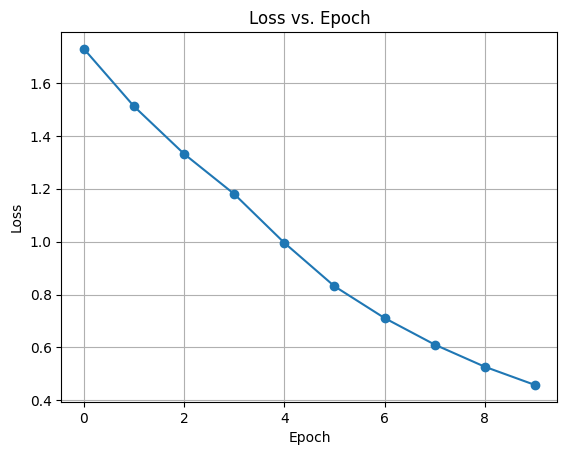

In [106]:

class LSTM(torch.nn.Module):
  def __init__(self, vocabulary_size,embed_size,hidden_dim,num_layers,num_classes):
    super().__init__()

    self.embedding_module = torch.nn.Embedding(vocabulary_size, embed_size)
    self.hidden_dim = hidden_dim
    self.lstm = torch.nn.LSTM(embed_size,hidden_dim,num_layers,batch_first=True)
    self.outLayer = torch.nn.Linear(hidden_dim,num_classes)
    self.num_classes = num_classes

  def forward(self, sentence):
    # Take the word index and return an "unnormalized probability distribution" over the labels (1 and 0)
    embedding = self.embedding_module(sentence)

    out, _ = self.lstm(embedding)
    prob_dist = self.outLayer(out)
    softened = torch.nn.functional.log_softmax(prob_dist,dim=2)
    return softened.view(-1,self.num_classes)


lstm_data = LSTMDataset(data)
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
lstm_data_loader =  DataLoader(lstm_data, batch_size=3, shuffle=True,collate_fn=lstm_data.collate)
lstm_val_data = read_conllu("en_atis-ud-dev.conllu")
lstm_val_dataset = LSTMDataset(lstm_val_data,lstm_data.posTags,lstm_data.vocabulary)

lstm_val_dataloader = DataLoader(lstm_val_dataset, batch_size=3,collate_fn=lstm_data.collate)


lstm_model = LSTM(len(lstm_data.vocabulary),128,64,2,len(lstm_data.posTags))
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(lstm_model.parameters(),lr = 0.01)
epoch_id = []
losses = []

for epoch_num in range(10):
  # Put model in training mode
  lstm_model.train()
  for batch_num, (sentences, tags) in enumerate(lstm_data_loader):

    pred = lstm_model(sentences)
    tags = tags.view(-1)
    # print(pred,tags)

    loss = loss_fn(pred,tags)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch_num % 100 == 0:
      # print loss every 2 steps
      print(f"{batch_num=}, {loss.item()=}")
  lstm_model.eval()
  with torch.no_grad():
    # Can experiment calculating accuracies
    test_loss = 0
    for batch_num, (words, tags) in enumerate(lstm_val_dataloader):
      pred = lstm_model(words)
      test_loss += loss_fn(pred, tags.view(-1))
    print(f"Validation error: {test_loss/len(lstm_val_dataloader)}")
    epoch_id.append(epoch_num)
    losses.append(test_loss/len(lstm_val_dataloader))

lstm_model.eval()

true_labels = []
predicted_labels = []

# Iterate over test set
for words, labels in lstm_val_dataloader:
    # Forward pass
    outputs = lstm_model(words)

    # Get predicted labels
    _, predicted = torch.max(outputs, 1)

    # Append true and predicted labels
    true_labels.extend(labels.view(-1).tolist())
    predicted_labels.extend(predicted.tolist())

# Compute evaluation metrics
print(true_labels,predicted)
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels,average="weighted")
f1 = f1_score(true_labels, predicted_labels,average="weighted")
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

import matplotlib.pyplot as plt
plt.plot(epoch_id, losses, marker='o', linestyle='-')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()




In [85]:

class LSTM(torch.nn.Module):
  def __init__(self, vocabulary_size,embed_size,hidden_dim,num_layers,num_classes):
    super().__init__()

    self.embedding_module = torch.nn.Embedding(vocabulary_size, embed_size)
    self.hidden_dim = hidden_dim
    self.lstm = torch.nn.LSTM(embed_size,hidden_dim,num_layers,batch_first=True)
    self.outLayer = torch.nn.Linear(hidden_dim,num_classes)
    self.num_classes = num_classes

  def forward(self, sentence):
    # Take the word index and return an "unnormalized probability distribution" over the labels (1 and 0)
    embedding = self.embedding_module(sentence)

    out, _ = self.lstm(embedding)
    prob_dist = self.outLayer(out)
    softened = torch.nn.functional.log_softmax(prob_dist,dim=2)
    return softened.view(-1,self.num_classes)


lstm_data = LSTMDataset(data)
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
lstm_data_loader =  DataLoader(lstm_data, batch_size=3, shuffle=True,collate_fn=lstm_data.collate)
lstm_val_data = read_conllu("en_atis-ud-dev.conllu")
lstm_val_dataset = LSTMDataset(lstm_val_data,lstm_data.posTags,lstm_data.vocabulary)

lstm_val_dataloader = DataLoader(lstm_val_dataset, batch_size=3,collate_fn=lstm_data.collate)


lstm_model = LSTM(len(lstm_data.vocabulary),128,64,1,len(lstm_data.posTags))
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(lstm_model.parameters(),lr = 0.01)

for epoch_num in range(10):
  # Put model in training mode
  lstm_model.train()
  for batch_num, (sentences, tags) in enumerate(lstm_data_loader):

    pred = lstm_model(sentences)
    tags = tags.view(-1)
    # print(pred,tags)

    loss = loss_fn(pred,tags)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch_num % 100 == 0:
      # print loss every 2 steps
      print(f"{batch_num=}, {loss.item()=}")
      lstm_model.eval()
      with torch.no_grad():
        # Can experiment calculating accuracies
        test_loss = 0
        for batch_num, (words, tags) in enumerate(lstm_val_dataloader):
          pred = lstm_model(words)
          test_loss += loss_fn(pred, tags.view(-1))
        print(f"Validation error: {test_loss/len(lstm_val_dataloader)}")

lstm_model.eval()

true_labels = []
predicted_labels = []

# Iterate over test set
for words, labels in lstm_val_dataloader:
    # Forward pass
    outputs = lstm_model(words)

    # Get predicted labels
    _, predicted = torch.max(outputs, 1)

    # Append true and predicted labels
    true_labels.extend(labels.view(-1).tolist())
    predicted_labels.extend(predicted.tolist())

# Compute evaluation metrics
print(true_labels,predicted)
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels,average="weighted")
f1 = f1_score(true_labels, predicted_labels,average="weighted")
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)


batch_num=0, loss.item()=2.768831968307495
Validation error: 2.753700017929077
batch_num=100, loss.item()=2.287932872772217
Validation error: 2.3433568477630615
batch_num=200, loss.item()=2.0352556705474854
Validation error: 2.0845999717712402
batch_num=300, loss.item()=1.5813994407653809
Validation error: 1.930659532546997
batch_num=400, loss.item()=1.5467183589935303
Validation error: 1.8154546022415161
batch_num=500, loss.item()=1.399301528930664
Validation error: 1.7144253253936768
batch_num=600, loss.item()=1.1384450197219849
Validation error: 1.6318576335906982
batch_num=700, loss.item()=1.3242207765579224
Validation error: 1.5576142072677612
batch_num=800, loss.item()=1.5539312362670898
Validation error: 1.495394229888916
batch_num=900, loss.item()=1.6246471405029297
Validation error: 1.434155821800232
batch_num=1000, loss.item()=1.2417259216308594
Validation error: 1.3807759284973145
batch_num=1100, loss.item()=1.2944053411483765
Validation error: 1.3318002223968506
batch_num=1

In [86]:

class LSTM(torch.nn.Module):
  def __init__(self, vocabulary_size,embed_size,hidden_dim,num_layers,num_classes):
    super().__init__()

    self.embedding_module = torch.nn.Embedding(vocabulary_size, embed_size)
    self.hidden_dim = hidden_dim
    self.lstm = torch.nn.LSTM(embed_size,hidden_dim,num_layers,batch_first=True)
    self.outLayer = torch.nn.Linear(hidden_dim,num_classes)
    self.num_classes = num_classes

  def forward(self, sentence):
    # Take the word index and return an "unnormalized probability distribution" over the labels (1 and 0)
    embedding = self.embedding_module(sentence)

    out, _ = self.lstm(embedding)
    prob_dist = self.outLayer(out)
    softened = torch.nn.functional.log_softmax(prob_dist,dim=2)
    return softened.view(-1,self.num_classes)


lstm_data = LSTMDataset(data)
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
lstm_data_loader =  DataLoader(lstm_data, batch_size=3, shuffle=True,collate_fn=lstm_data.collate)
lstm_val_data = read_conllu("en_atis-ud-dev.conllu")
lstm_val_dataset = LSTMDataset(lstm_val_data,lstm_data.posTags,lstm_data.vocabulary)

lstm_val_dataloader = DataLoader(lstm_val_dataset, batch_size=3,collate_fn=lstm_data.collate)


lstm_model = LSTM(len(lstm_data.vocabulary),128,64,3,len(lstm_data.posTags))
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(lstm_model.parameters(),lr = 0.01)

for epoch_num in range(10):
  # Put model in training mode
  lstm_model.train()
  for batch_num, (sentences, tags) in enumerate(lstm_data_loader):

    pred = lstm_model(sentences)
    tags = tags.view(-1)
    # print(pred,tags)

    loss = loss_fn(pred,tags)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch_num % 100 == 0:
      # print loss every 2 steps
      print(f"{batch_num=}, {loss.item()=}")
      lstm_model.eval()
      with torch.no_grad():
        # Can experiment calculating accuracies
        test_loss = 0
        for batch_num, (words, tags) in enumerate(lstm_val_dataloader):
          pred = lstm_model(words)
          test_loss += loss_fn(pred, tags.view(-1))
        print(f"Validation error: {test_loss/len(lstm_val_dataloader)}")

lstm_model.eval()

true_labels = []
predicted_labels = []

# Iterate over test set
for words, labels in lstm_val_dataloader:
    # Forward pass
    outputs = lstm_model(words)

    # Get predicted labels
    _, predicted = torch.max(outputs, 1)

    # Append true and predicted labels
    true_labels.extend(labels.view(-1).tolist())
    predicted_labels.extend(predicted.tolist())

# Compute evaluation metrics
print(true_labels,predicted)
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels,average="weighted")
f1 = f1_score(true_labels, predicted_labels,average="weighted")
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)


batch_num=0, loss.item()=2.756009340286255
Validation error: 2.730137348175049
batch_num=100, loss.item()=2.5651419162750244
Validation error: 2.6256895065307617
batch_num=200, loss.item()=2.562382698059082
Validation error: 2.5338683128356934
batch_num=300, loss.item()=2.3540215492248535
Validation error: 2.4509072303771973
batch_num=400, loss.item()=2.334911346435547
Validation error: 2.375304937362671
batch_num=500, loss.item()=2.3398396968841553
Validation error: 2.3092126846313477
batch_num=600, loss.item()=2.258181571960449
Validation error: 2.255188226699829
batch_num=700, loss.item()=2.2800559997558594
Validation error: 2.213348627090454
batch_num=800, loss.item()=2.1152405738830566
Validation error: 2.180863380432129
batch_num=900, loss.item()=2.0917131900787354
Validation error: 2.1578567028045654
batch_num=1000, loss.item()=2.0314552783966064
Validation error: 2.138705015182495
batch_num=1100, loss.item()=1.8998180627822876
Validation error: 2.1242620944976807
batch_num=1200

batch_num=0, loss.item()=2.712655782699585
batch_num=100, loss.item()=2.067690372467041
batch_num=200, loss.item()=2.3302714824676514
batch_num=300, loss.item()=1.9364749193191528
batch_num=400, loss.item()=1.7552138566970825
batch_num=500, loss.item()=1.568009376525879
batch_num=600, loss.item()=1.2894550561904907
batch_num=700, loss.item()=1.6028964519500732
batch_num=800, loss.item()=1.685049057006836
batch_num=900, loss.item()=1.4511566162109375
batch_num=1000, loss.item()=0.9557900428771973
batch_num=1100, loss.item()=1.5733847618103027
batch_num=1200, loss.item()=1.0374131202697754
batch_num=1300, loss.item()=0.9901220202445984
batch_num=1400, loss.item()=1.384611964225769
Validation error: 1.1439646482467651
batch_num=0, loss.item()=1.181931495666504
batch_num=100, loss.item()=0.9748337864875793
batch_num=200, loss.item()=1.017088532447815
batch_num=300, loss.item()=1.0280425548553467
batch_num=400, loss.item()=1.3495497703552246
batch_num=500, loss.item()=1.19452702999115
batch

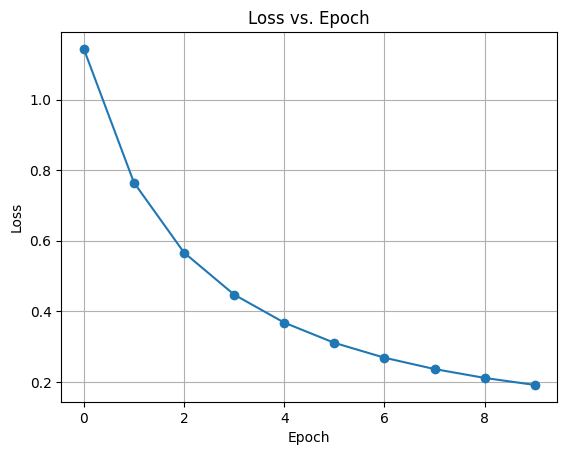

In [104]:

class LSTM(torch.nn.Module):
  def __init__(self, vocabulary_size,embed_size,hidden_dim,num_layers,num_classes):
    super().__init__()

    self.embedding_module = torch.nn.Embedding(vocabulary_size, embed_size)
    self.hidden_dim = hidden_dim
    self.lstm = torch.nn.LSTM(embed_size,hidden_dim,num_layers,batch_first=True,bidirectional=True)
    self.outLayer = torch.nn.Linear(hidden_dim*2,num_classes)
    self.num_classes = num_classes

  def forward(self, sentence):
    # Take the word index and return an "unnormalized probability distribution" over the labels (1 and 0)
    embedding = self.embedding_module(sentence)

    out, _ = self.lstm(embedding)
    prob_dist = self.outLayer(out)
    softened = torch.nn.functional.log_softmax(prob_dist,dim=2)
    return softened.view(-1,self.num_classes)


lstm_data = LSTMDataset(data)
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
lstm_data_loader =  DataLoader(lstm_data, batch_size=3, shuffle=True,collate_fn=lstm_data.collate)
lstm_val_data = read_conllu("en_atis-ud-test.conllu")
lstm_val_dataset = LSTMDataset(lstm_val_data,lstm_data.posTags,lstm_data.vocabulary)

lstm_val_dataloader = DataLoader(lstm_val_dataset, batch_size=3,collate_fn=lstm_data.collate)


lstm_model = LSTM(len(lstm_data.vocabulary),128,64,1,len(lstm_data.posTags))
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(lstm_model.parameters(),lr = 0.01)

epoch_id = []
losses = []

for epoch_num in range(10):
  # Put model in training mode
  lstm_model.train()
  for batch_num, (sentences, tags) in enumerate(lstm_data_loader):

    pred = lstm_model(sentences)
    tags = tags.view(-1)
    # print(pred,tags)

    loss = loss_fn(pred,tags)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch_num % 100 == 0:
      # print loss every 2 steps
      print(f"{batch_num=}, {loss.item()=}")
  lstm_model.eval()
  with torch.no_grad():
    # Can experiment calculating accuracies
    test_loss = 0
    for batch_num, (words, tags) in enumerate(lstm_val_dataloader):
      pred = lstm_model(words)
      test_loss += loss_fn(pred, tags.view(-1))
    print(f"Validation error: {test_loss/len(lstm_val_dataloader)}")
    epoch_id.append(epoch_num)
    losses.append(test_loss/len(lstm_val_dataloader))

lstm_model.eval()

true_labels = []
predicted_labels = []

# Iterate over test set
for words, labels in lstm_val_dataloader:
    # Forward pass
    outputs = lstm_model(words)

    # Get predicted labels
    _, predicted = torch.max(outputs, 1)

    # Append true and predicted labels
    true_labels.extend(labels.view(-1).tolist())
    predicted_labels.extend(predicted.tolist())

# Compute evaluation metrics
print(true_labels,predicted)
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels,average="weighted")
f1 = f1_score(true_labels, predicted_labels,average="weighted")
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

import matplotlib.pyplot as plt
plt.plot(epoch_id, losses, marker='o', linestyle='-')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()



In [97]:

class LSTM(torch.nn.Module):
  def __init__(self, vocabulary_size,embed_size,hidden_dim,num_layers,num_classes):
    super().__init__()

    self.embedding_module = torch.nn.Embedding(vocabulary_size, embed_size)
    self.hidden_dim = hidden_dim
    self.lstm = torch.nn.LSTM(embed_size,hidden_dim,num_layers,batch_first=True,bidirectional=True)
    self.outLayer = torch.nn.Sequential(
        torch.nn.Linear(2*hidden_dim,64),
        torch.nn.ReLU(),
        torch.nn.Linear(64,num_classes)
    )
    self.num_classes = num_classes

  def forward(self, sentence):
    # Take the word index and return an "unnormalized probability distribution" over the labels (1 and 0)
    embedding = self.embedding_module(sentence)

    out, _ = self.lstm(embedding)
    prob_dist = self.outLayer(out)
    softened = torch.nn.functional.log_softmax(prob_dist,dim=2)
    return softened.view(-1,self.num_classes)


lstm_data = LSTMDataset(data)
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
lstm_data_loader =  DataLoader(lstm_data, batch_size=3, shuffle=True,collate_fn=lstm_data.collate)
lstm_val_data = read_conllu("en_atis-ud-test.conllu")
lstm_val_dataset = LSTMDataset(lstm_val_data,lstm_data.posTags,lstm_data.vocabulary)

lstm_val_dataloader = DataLoader(lstm_val_dataset, batch_size=3,collate_fn=lstm_data.collate)


lstm_model = LSTM(len(lstm_data.vocabulary),128,64,1,len(lstm_data.posTags))
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(lstm_model.parameters(),lr = 0.01)

for epoch_num in range(10):
  # Put model in training mode
  lstm_model.train()
  for batch_num, (sentences, tags) in enumerate(lstm_data_loader):

    pred = lstm_model(sentences)
    tags = tags.view(-1)
    # print(pred,tags)

    loss = loss_fn(pred,tags)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch_num % 100 == 0:
      # print loss every 2 steps
      print(f"{batch_num=}, {loss.item()=}")
      lstm_model.eval()
      with torch.no_grad():
        # Can experiment calculating accuracies
        test_loss = 0
        for batch_num, (words, tags) in enumerate(lstm_val_dataloader):
          pred = lstm_model(words)
          test_loss += loss_fn(pred, tags.view(-1))
        print(f"Validation error: {test_loss/len(lstm_val_dataloader)}")

lstm_model.eval()

true_labels = []
predicted_labels = []

# Iterate over test set
for words, labels in lstm_val_dataloader:
    # Forward pass
    outputs = lstm_model(words)

    # Get predicted labels
    _, predicted = torch.max(outputs, 1)

    # Append true and predicted labels
    true_labels.extend(labels.view(-1).tolist())
    predicted_labels.extend(predicted.tolist())

# Compute evaluation metrics
print(true_labels,predicted)
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels,average="weighted")
f1 = f1_score(true_labels, predicted_labels,average="weighted")
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)


batch_num=0, loss.item()=2.6952409744262695
Validation error: 2.707214593887329
batch_num=100, loss.item()=2.4843406677246094
Validation error: 2.503622531890869
batch_num=200, loss.item()=2.141235113143921
Validation error: 2.1979236602783203
batch_num=300, loss.item()=2.057706832885742
Validation error: 2.0227208137512207
batch_num=400, loss.item()=1.887357473373413
Validation error: 1.919845461845398
batch_num=500, loss.item()=1.7371182441711426
Validation error: 1.825815200805664
batch_num=600, loss.item()=1.6871074438095093
Validation error: 1.7388827800750732
batch_num=700, loss.item()=1.327851414680481
Validation error: 1.6581761837005615
batch_num=800, loss.item()=1.4081597328186035
Validation error: 1.5873140096664429
batch_num=900, loss.item()=1.3093198537826538
Validation error: 1.5281627178192139
batch_num=1000, loss.item()=1.5595983266830444
Validation error: 1.4732484817504883
batch_num=1100, loss.item()=1.081199288368225
Validation error: 1.419748067855835
batch_num=1200

batch_num=0, loss.item()=2.7693817615509033
batch_num=100, loss.item()=2.298079490661621
batch_num=200, loss.item()=2.287947177886963
batch_num=300, loss.item()=1.464001178741455
batch_num=400, loss.item()=1.9174354076385498
batch_num=500, loss.item()=1.5411738157272339
batch_num=600, loss.item()=1.367482304573059
batch_num=700, loss.item()=1.2479788064956665
batch_num=800, loss.item()=1.3176578283309937
batch_num=900, loss.item()=1.4981858730316162
batch_num=1000, loss.item()=0.9890647530555725
batch_num=1100, loss.item()=1.5384902954101562
batch_num=1200, loss.item()=1.1358258724212646
batch_num=1300, loss.item()=1.0673171281814575
batch_num=1400, loss.item()=0.7056277990341187
Validation error: 1.0773683786392212
batch_num=0, loss.item()=1.0231893062591553
batch_num=100, loss.item()=1.5886892080307007
batch_num=200, loss.item()=0.9012283086776733
batch_num=300, loss.item()=0.956823468208313
batch_num=400, loss.item()=1.245158314704895
batch_num=500, loss.item()=1.0127941370010376
ba

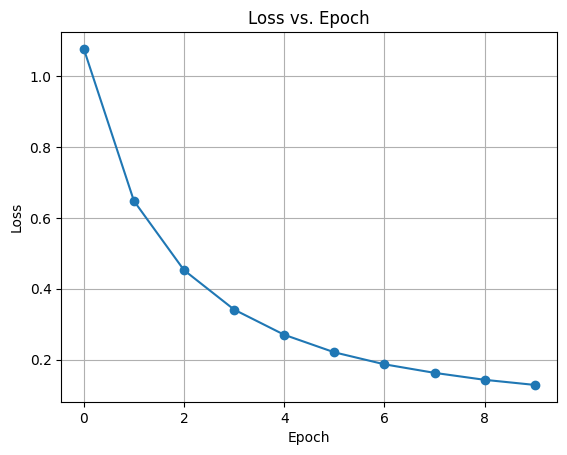

In [103]:

class LSTM(torch.nn.Module):
  def __init__(self, vocabulary_size,embed_size,hidden_dim,num_layers,num_classes):
    super().__init__()

    self.embedding_module = torch.nn.Embedding(vocabulary_size, embed_size)
    self.hidden_dim = hidden_dim
    self.lstm = torch.nn.LSTM(embed_size,hidden_dim,num_layers,batch_first=True,bidirectional=True)
    self.outLayer = torch.nn.Sequential(
        torch.nn.Linear(2*hidden_dim,64),
        torch.nn.Tanh(),
        torch.nn.Linear(64,num_classes)
    )
    self.num_classes = num_classes

  def forward(self, sentence):
    # Take the word index and return an "unnormalized probability distribution" over the labels (1 and 0)
    embedding = self.embedding_module(sentence)

    out, _ = self.lstm(embedding)
    prob_dist = self.outLayer(out)
    softened = torch.nn.functional.log_softmax(prob_dist,dim=2)
    return softened.view(-1,self.num_classes)


lstm_data = LSTMDataset(data)
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
lstm_data_loader =  DataLoader(lstm_data, batch_size=3, shuffle=True,collate_fn=lstm_data.collate)
lstm_val_data = read_conllu("en_atis-ud-dev.conllu")
lstm_val_dataset = LSTMDataset(lstm_val_data,lstm_data.posTags,lstm_data.vocabulary)

lstm_val_dataloader = DataLoader(lstm_val_dataset, batch_size=3,collate_fn=lstm_data.collate)


lstm_model = LSTM(len(lstm_data.vocabulary),128,64,1,len(lstm_data.posTags))
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(lstm_model.parameters(),lr = 0.01)
epoch_id = []
losses = []

for epoch_num in range(10):
  # Put model in training mode
  lstm_model.train()
  for batch_num, (sentences, tags) in enumerate(lstm_data_loader):

    pred = lstm_model(sentences)
    tags = tags.view(-1)
    # print(pred,tags)

    loss = loss_fn(pred,tags)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch_num % 100 == 0:
      # print loss every 2 steps
      print(f"{batch_num=}, {loss.item()=}")
  lstm_model.eval()
  with torch.no_grad():
    # Can experiment calculating accuracies
    test_loss = 0
    for batch_num, (words, tags) in enumerate(lstm_val_dataloader):
      pred = lstm_model(words)
      test_loss += loss_fn(pred, tags.view(-1))
    print(f"Validation error: {test_loss/len(lstm_val_dataloader)}")
    epoch_id.append(epoch_num)
    losses.append(test_loss/len(lstm_val_dataloader))

lstm_model.eval()

true_labels = []
predicted_labels = []

# Iterate over test set
for words, labels in lstm_val_dataloader:
    # Forward pass
    outputs = lstm_model(words)

    # Get predicted labels
    _, predicted = torch.max(outputs, 1)

    # Append true and predicted labels
    true_labels.extend(labels.view(-1).tolist())
    predicted_labels.extend(predicted.tolist())

# Compute evaluation metrics
print(true_labels,predicted)
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels,average="weighted")
f1 = f1_score(true_labels, predicted_labels,average="weighted")
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

import matplotlib.pyplot as plt
plt.plot(epoch_id, losses, marker='o', linestyle='-')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [99]:

class LSTM(torch.nn.Module):
  def __init__(self, vocabulary_size,embed_size,hidden_dim,num_layers,num_classes):
    super().__init__()

    self.embedding_module = torch.nn.Embedding(vocabulary_size, embed_size)
    self.hidden_dim = hidden_dim
    self.lstm = torch.nn.LSTM(embed_size,hidden_dim,num_layers,batch_first=True,bidirectional=True)
    self.outLayer = torch.nn.Sequential(
        torch.nn.Linear(2*hidden_dim,64),
        torch.nn.Sigmoid(),
        torch.nn.Linear(64,num_classes)
    )
    self.num_classes = num_classes

  def forward(self, sentence):
    # Take the word index and return an "unnormalized probability distribution" over the labels (1 and 0)
    embedding = self.embedding_module(sentence)

    out, _ = self.lstm(embedding)
    prob_dist = self.outLayer(out)
    softened = torch.nn.functional.log_softmax(prob_dist,dim=2)
    return softened.view(-1,self.num_classes)


lstm_data = LSTMDataset(data)
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
lstm_data_loader =  DataLoader(lstm_data, batch_size=3, shuffle=True,collate_fn=lstm_data.collate)
lstm_val_data = read_conllu("en_atis-ud-dev.conllu")
lstm_val_dataset = LSTMDataset(lstm_val_data,lstm_data.posTags,lstm_data.vocabulary)

lstm_val_dataloader = DataLoader(lstm_val_dataset, batch_size=3,collate_fn=lstm_data.collate)


lstm_model = LSTM(len(lstm_data.vocabulary),128,64,1,len(lstm_data.posTags))
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(lstm_model.parameters(),lr = 0.01)

for epoch_num in range(10):
  # Put model in training mode
  lstm_model.train()
  for batch_num, (sentences, tags) in enumerate(lstm_data_loader):

    pred = lstm_model(sentences)
    tags = tags.view(-1)
    # print(pred,tags)

    loss = loss_fn(pred,tags)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch_num % 100 == 0:
      # print loss every 2 steps
      print(f"{batch_num=}, {loss.item()=}")
      lstm_model.eval()
      with torch.no_grad():
        # Can experiment calculating accuracies
        test_loss = 0
        for batch_num, (words, tags) in enumerate(lstm_val_dataloader):
          pred = lstm_model(words)
          test_loss += loss_fn(pred, tags.view(-1))
        print(f"Validation error: {test_loss/len(lstm_val_dataloader)}")

lstm_model.eval()

true_labels = []
predicted_labels = []

# Iterate over test set
for words, labels in lstm_val_dataloader:
    # Forward pass
    outputs = lstm_model(words)

    # Get predicted labels
    _, predicted = torch.max(outputs, 1)

    # Append true and predicted labels
    true_labels.extend(labels.view(-1).tolist())
    predicted_labels.extend(predicted.tolist())

# Compute evaluation metrics
print(true_labels,predicted)
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels,average="weighted")
f1 = f1_score(true_labels, predicted_labels,average="weighted")
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)


batch_num=0, loss.item()=2.6597139835357666
Validation error: 2.711237907409668
batch_num=100, loss.item()=2.440053939819336
Validation error: 2.2348878383636475
batch_num=200, loss.item()=1.9624013900756836
Validation error: 2.1694905757904053
batch_num=300, loss.item()=1.850527048110962
Validation error: 2.1409003734588623
batch_num=400, loss.item()=2.255742311477661
Validation error: 2.116132974624634
batch_num=500, loss.item()=2.052717447280884
Validation error: 2.0916075706481934
batch_num=600, loss.item()=1.9053738117218018
Validation error: 2.0628342628479004
batch_num=700, loss.item()=1.8536120653152466
Validation error: 2.0261683464050293
batch_num=800, loss.item()=2.0049948692321777
Validation error: 1.9833519458770752
batch_num=900, loss.item()=2.173058032989502
Validation error: 1.9387753009796143
batch_num=1000, loss.item()=1.9676694869995117
Validation error: 1.8927496671676636
batch_num=1100, loss.item()=2.0127594470977783
Validation error: 1.851394772529602
batch_num=12

In [91]:
torch.save(lstm_model,"lstm.pt")
torch.save(lstm_data.posTags,"lstmTags.pt")
torch.save(lstm_data.vocabulary,"lstmVocab.pt")
print(true_labels)
print(predicted_labels)



[7, 8, 5, 6, 9, 4, 3, 2, 3, 2, 5, 4, 10, 9, 11, 5, 4, 9, 7, 5, 6, 4, 3, 2, 3, 2, 3, 5, 6, 12, 3, 10, 4, 1, 1, 1, 5, 7, 4, 4, 4, 3, 2, 3, 2, 5, 9, 4, 11, 5, 6, 4, 3, 1, 7, 8, 2, 2, 5, 3, 3, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 7, 6, 4, 3, 2, 3, 2, 6, 5, 3, 10, 12, 4, 6, 4, 3, 4, 6, 4, 3, 2, 3, 2, 5, 9, 3, 6, 4, 1, 1, 1, 1, 1, 1, 1, 8, 7, 5, 4, 3, 4, 3, 2, 2, 3, 2, 2, 5, 3, 4, 1, 1, 5, 6, 2, 2, 4, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 6, 4, 5, 3, 2, 3, 2, 2, 3, 2, 4, 5, 3, 3, 2, 2, 7, 8, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 5, 4, 3, 4, 4, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 7, 8, 6, 9, 4, 3, 2, 2, 3, 2, 5, 3, 4, 4, 10, 10, 7, 8, 5, 3, 5, 6, 4, 3, 4, 9, 3, 2, 2, 3, 2, 3, 6, 9, 4, 7, 8, 4, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 11, 12, 5, 7, 4, 4, 3, 7, 8, 5, 3, 2, 9, 4, 1, 1, 1, 1, 1, 5, 7, 6, 9, 4, 3, 2, 3, 2, 3, 5, 3, 6, 4, 11, 5, 3, 10, 4, 11, 10, 4, 1, 1, 3, 4, 7, 8, 5, 13, 5, 3, 2, 2, 2, 3, 2, 2, 7, 8, 5, 3, 5, 3, 2, 3, 10, 4, 5, 7, 6, 4, 4, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1

In [26]:

class LSTM(torch.nn.Module):
  def __init__(self, vocabulary_size,embed_size,hidden_dim,num_layers,num_classes):
    super().__init__()

    self.embedding_module = torch.nn.Embedding(vocabulary_size, embed_size)
    self.hidden_dim = hidden_dim
    self.lstm = torch.nn.LSTM(embed_size,hidden_dim,num_layers,batch_first=True)
    self.outLayer = torch.nn.Linear(hidden_dim,num_classes)
    self.num_classes = num_classes

  def forward(self, sentence):
    # Take the word index and return an "unnormalized probability distribution" over the labels (1 and 0)
    embedding = self.embedding_module(sentence)

    out, _ = self.lstm(embedding)
    prob_dist = self.outLayer(out)
    softened = torch.nn.functional.log_softmax(prob_dist,dim=2)
    return softened.view(-1,self.num_classes)


lstm_data = LSTMDataset(data)
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
lstm_data_loader =  DataLoader(lstm_data, batch_size=3, shuffle=True,collate_fn=lstm_data.collate)
lstm_val_data = read_conllu("en_atis-ud-dev.conllu")
lstm_val_dataset = LSTMDataset(lstm_val_data,lstm_data.posTags,lstm_data.vocabulary)

lstm_val_dataloader = DataLoader(lstm_val_dataset, batch_size=3,collate_fn=lstm_data.collate)


lstm_model = LSTM(len(lstm_data.vocabulary),32,64,3,len(lstm_data.posTags))
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(lstm_model.parameters(),lr = 0.01)

for epoch_num in range(10):
  # Put model in training mode
  lstm_model.train()
  for batch_num, (sentences, tags) in enumerate(lstm_data_loader):

    pred = lstm_model(sentences)
    tags = tags.view(-1)
    # print(pred,tags)

    loss = loss_fn(pred,tags)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch_num % 100 == 0:
      # print loss every 2 steps
      print(f"{batch_num=}, {loss.item()=}")
      lstm_model.eval()
      with torch.no_grad():
        # Can experiment calculating accuracies
        test_loss = 0
        for batch_num, (words, tags) in enumerate(lstm_val_dataloader):
          pred = lstm_model(words)
          test_loss += loss_fn(pred, tags.view(-1))
        print(f"Validation error: {test_loss/len(lstm_val_dataloader)}")

lstm_model.eval()

true_labels = []
predicted_labels = []

# Iterate over test set
for words, labels in lstm_val_dataloader:
    # Forward pass
    outputs = lstm_model(words)

    # Get predicted labels
    _, predicted = torch.max(outputs, 1)

    # Append true and predicted labels
    true_labels.extend(labels.view(-1).tolist())
    predicted_labels.extend(predicted.tolist())

# Compute evaluation metrics
print(true_labels,predicted)
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels,average="weighted")
f1 = f1_score(true_labels, predicted_labels,average="weighted")
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)


batch_num=0, loss.item()=2.708308696746826
Validation error: 2.714724540710449
batch_num=100, loss.item()=2.628638744354248
Validation error: 2.606328248977661
batch_num=200, loss.item()=2.5072312355041504
Validation error: 2.514258623123169
batch_num=300, loss.item()=2.495018243789673
Validation error: 2.4243195056915283
batch_num=400, loss.item()=2.439249277114868
Validation error: 2.3434886932373047
batch_num=500, loss.item()=2.126676082611084
Validation error: 2.2738912105560303
batch_num=600, loss.item()=2.1874048709869385
Validation error: 2.221719741821289
batch_num=700, loss.item()=2.2804737091064453
Validation error: 2.184147357940674
batch_num=800, loss.item()=2.263683795928955
Validation error: 2.1589410305023193
batch_num=900, loss.item()=2.32847261428833
Validation error: 2.138892889022827
batch_num=1000, loss.item()=2.0810253620147705
Validation error: 2.1216728687286377
batch_num=1100, loss.item()=2.1948235034942627
Validation error: 2.110678195953369
batch_num=1200, los